<a href="https://colab.research.google.com/github/vincent-grari/DIVERS/blob/main/Pricingame_2015_S3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import sys
print(sys.argv)
import os
import urllib
import os.path
import sklearn.preprocessing as preprocessing
from collections import namedtuple
import pandas as pd

['/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py', '-f', '/root/.local/share/jupyter/runtime/kernel-b6b586ab-1c14-45c7-ba71-b94bca69ab37.json']


In [2]:
!pip3 install geojsoncontour

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [27]:
pg15training = pd.read_csv("http://grarivincent.com/fairness/data/pg15training.csv", #names=column_names,
                                sep=r',', engine='python', na_values=['NA'])

#pg15pricing = (pd.read_csv("http://grarivincent.com/fairness/data/pg15pricing.csv", #names=column_names,
#                                sep=r',', engine='python', na_values=['NA']))
pg15training=pg15training[pg15training['Indtppd']>0]

In [28]:
pg15training.shape

(12256, 20)

In [29]:
import pandas as pd
X = pg15training.drop(columns= ['Gender','PolNum','CalYear','Numtppd'	,'Numtpbi',	'Indtppd'	,'Indtpbi','Exppdays','SubGroup2',	'Group2',	'Density','Adind','Type', 'Category', 'Group1', 'Value'])
Y = pg15training['Indtppd']
E = pg15training['Exppdays']
I = pg15training[['SubGroup2',	'Group2']]
G = pd.DataFrame(data=pg15training['Density'], columns=["Density"])
S1 = pg15training['Gender']=='Male'
V = pg15training[['Type', 'Category', 'Group1', 'Value']]

X = (X.fillna('Unknown').pipe(pd.get_dummies))
V = (V.fillna('Unknown').pipe(pd.get_dummies))


In [31]:
X_train, X_test, y_train, y_test, G_train, G_test,V_train, V_test, E_train, E_test, I_train, I_test, S1_train, S1_test = train_test_split(X, Y, G,V,  E, I, S1, test_size=0.2, random_state=7)

In [32]:
scaler = StandardScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler)

In [33]:
scalerg = StandardScaler().fit(G_train)
scale_df_g = lambda df, scaler: pd.DataFrame(scalerg.transform(df), columns=df.columns, index=df.index)
G_train = G_train.pipe(scale_df_g, scalerg) 
G_test = G_test.pipe(scale_df_g, scalerg)

In [34]:
scalerv = StandardScaler().fit(V_train)
scale_df_v = lambda df, scaler: pd.DataFrame(scalerv.transform(df), columns=df.columns, index=df.index)
V_train = V_train.pipe(scale_df_v, scalerv) 
V_test = V_test.pipe(scale_df_v, scalerv)

In [35]:
y_traint =np.expand_dims(y_train,axis=1)
y_testt =np.expand_dims(y_test,axis=1)

In [36]:
V_train.head()

,Group1,Value,Type_A,Type_B,Type_C,Type_D,Type_E,Type_F,Category_Large,Category_Medium,Category_Small
99002,1.814983,-0.511647,1.758843,-0.508624,-0.404744,-0.519407,-0.386814,-0.267568,-0.647158,-0.764767,1.406460
70768,0.056282,-0.787290,1.758843,-0.508624,-0.404744,-0.519407,-0.386814,-0.267568,-0.647158,-0.764767,1.406460
90409,-0.163555,-0.754752,-0.568556,-0.508624,2.470698,-0.519407,-0.386814,-0.267568,-0.647158,-0.764767,1.406460
7393,0.935633,-0.633897,1.758843,-0.508624,-0.404744,-0.519407,-0.386814,-0.267568,-0.647158,-0.764767,1.406460
23652,-0.603230,-0.471207,-0.568556,-0.508624,2.470698,-0.519407,-0.386814,-0.267568,-0.647158,1.307587,-0.711005


### **GLM POISSON SANS ZONIER **

ZONIER

In [43]:
XZ = pd.concat([X_train,V_train], ignore_index=True, verify_integrity=True, axis=1)
from sklearn import linear_model
import statsmodels.api as sm

reg = linear_model.GammaRegressor() 
reg.fit(XZ,y_train)
#reg = sm.GLM(y_train, XZ, family=sm.families.Gaussian()).fit()

GammaRegressor()

In [44]:
Res_GLM = ((reg.predict(XZ)-y_train))

In [46]:
gamma_model_res = sm.GLM(Res_GLM, G_train, family=sm.families.Gaussian())
Predict_res = gamma_model_res.fit()

In [47]:
qcut = 20
ZONIER= pd.qcut(Predict_res.predict(), q=qcut, labels=False)/qcut

VEHICULIER

In [79]:
XV['ZONIER']=ZONIER
XV=X_train.copy()
from sklearn import linear_model
#reg = linear_model.PoissonRegressor() 
#reg.fit(XV,y_train)
#reg = sm.GLM(y_train, XV, exposure = E_train, family=sm.families.Poisson()).fit()
reg = linear_model.GammaRegressor() 
reg.fit(XV,y_train)

GammaRegressor()

In [90]:
Res_GLM = ((reg.predict(XV)-y_train))

In [91]:
import statsmodels.api as sm
gamma_model_res = sm.GLM(Res_GLM, V_train, family=sm.families.Gaussian())
Predict_resVEH = gamma_model_res.fit()

In [92]:
qcut = 20
VEHICULIER= pd.qcut(Predict_resVEH.predict(), q=qcut, labels=False)/qcut

VEHICULIER

In [93]:
df1=  X_train.copy()
df2= pd.DataFrame(ZONIER, columns=['zonier'])
df2b= pd.DataFrame(VEHICULIER, columns=['vehiculier'])

df1.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)
df2b.reset_index(drop=True, inplace=True)

df3 = pd.concat([df1,df2,df2b], ignore_index=True, verify_integrity=True, axis=1)

In [94]:
import pandas as pd
from sklearn import linear_model
#regfinal = linear_model.PoissonRegressor()
#regfinal.fit(df3,y_train)
regfinal = linear_model.GammaRegressor() 
regfinal.fit(df3,y_train)
#regfinal = sm.GLM(list(y_train), df3, exposure = E_train, family=sm.families.Poisson()).fit()

GammaRegressor()

In [95]:
Yhat = regfinal.predict(df3)

In [96]:
#from sklearn.neighbors import KNeighborsRegressor
#knn_model = KNeighborsRegressor(n_neighbors=3)
#knn_model.fit(I_train2[['latitude','longitude']], X_trainZ2['ZC'])
#ZKNN = knn_model.predict(I_train2[['latitude','longitude']])

In [97]:
def EDR_POIS(yhat, y):
  #loss=torch.mean(torch.exp(xbeta)-y*xbeta)
  #loss=torch.mean(yhat-y*torch.log(yhat))
  eps=0.000000000001
  res=1-np.mean((y*np.log((y+eps)/yhat)-(y-yhat)))/np.mean((y*np.log((y+eps)/np.mean(y))))
  return res
def gini_coefficient(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

In [58]:
class HGR_MIN_NN(nn.Module):
    
    def __init__(self,model_F,model_G,model_Y):
        super(HGR_MIN_NN, self).__init__()
        self.mF = model_F
        self.mG = model_G
        self.mY = model_Y
        self.optimizer_F = torch.optim.Adam(self.mF.parameters(), lr=0.0005)
        self.optimizer_G = torch.optim.Adam(self.mG.parameters(), lr=0.0005)
        self.optimizer_Y = torch.optim.Adam(self.mY.parameters(), lr=0.0001)

    def forward(self, x_var, y2, y_traint,x_vart,y_testt, y2t,nb,num_epochs,avt,lamb):
        criterionY = RMSELoss()
        seuil = num_epochs-avt
        ret= torch.FloatTensor([0.])
        for epoch in range(num_epochs):
            if (epoch % (num_epochs) == 0) & (epoch!=0):
                print('Epoch {}'.format(epoch+1))
                y_pred2= self.mY(x_var).data.numpy()
                accuracy = np.mean((y_traint- y_pred2)**2)
                #HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
        
                y_pred2t= self.mY(x_vart).data.numpy()
                accuracyt = np.mean((y_testt- y_pred2t)**2)
                print ("Train MSE:", round(accuracy,4),"lossY",lossY, "HGR Train NN",ret.data.numpy(),
                       #"HGR Train NN2:", HGR_NNP(model_pred(x_var),y2_var),
                       #"HGR Train KDE:", hgr(model_pred(x_var).squeeze(1),y2_var.squeeze(1),kde).data.numpy(),
                       "Test MSE:", round(accuracyt,4),"mean_Ypred", y_pred2.mean())#,"X2 Test :",ret,)
        
            #ret=0
            #### Predictor Classifier ####
            y_var = torch.FloatTensor(y_traint)
            y2_var = torch.FloatTensor(y2)
            yhat= self.mY(x_var)
            lossY =criterionY(yhat, y_var)
            epsilon=0.0000000000000000001
            #print(yhat)
            if epoch >= seuil:  #10000000000
                for j in range(nb) :
                    #ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
                    #ret = torch.mean(pred_xy) - torch.mean(pred_x_y) - 0.25*torch.mean(torch.pow(pred_x_y,2))
        
                    yhat2  =yhat.data.numpy()
                    y2_var2=y2_var.data.numpy()
                
                    yhat2_PT  = torch.from_numpy(yhat2).type(torch.FloatTensor)
                    y2_var_PT = torch.from_numpy(y2_var2).type(torch.FloatTensor)

                    pred_F  = self.mF(yhat2_PT)
                    pred_G  = self.mG(y2_var_PT)
                    
                    #pred_F_norm = (pred_F-torch.mean(pred_F))/torch.std(pred_F)
                    #pred_G_norm = (pred_G-torch.mean(pred_G))/torch.std(pred_G)
        
                    epsilon=0.000001
                    pred_F_norm = (pred_F-torch.mean(pred_F))/torch.sqrt((torch.std(pred_F).pow(2)+epsilon))
                    pred_G_norm = (pred_G-torch.mean(pred_G))/torch.sqrt((torch.std(pred_G).pow(2)+epsilon))
                    #pred_F_norm[torch.isnan(pred_F_norm )] = 0
                    #pred_G_norm[torch.isnan(pred_G_norm )] = 0
                    
                    ret = torch.mean(pred_F_norm*pred_G_norm)
                    loss = - ret  # maximize
                    self.mF.zero_grad()
                    self.mG.zero_grad()
                    loss.backward()
                    #print(loss)
                    self.optimizer_F.step()
                    self.optimizer_G.step()
            
            if epoch >= seuil:
                pred_F  = self.mF(yhat)
                pred_G  = self.mG(y2_var)
                #val_std = torch.std(pred_F) 
                #if torch.std(pred_F) < 0.0000000000000000001 :
                #    val_std = 0.0000000000000000001 
            
                epsilon=0.00000000001 
                pred_F_norm = (pred_F-torch.mean(pred_F))/torch.sqrt((torch.std(pred_F).pow(2)+epsilon))
                pred_G_norm = (pred_G-torch.mean(pred_G))/torch.sqrt((torch.std(pred_G).pow(2)+epsilon))
                #pred_F_norm[torch.isnan(pred_F_norm )] = 0
                #pred_G_norm[torch.isnan(pred_G_norm )] = 0

                ret = torch.mean(pred_F_norm*pred_G_norm)  
            if epoch < seuil:
                ret= torch.FloatTensor([0.])
            loss =lossY + lamb*ret  #.data.numpy() 190
            #print(loss**2)
            self.optimizer_Y.zero_grad()
            loss.backward()
            #clip_value=0.000001
            #torch.nn.utils.clip_grad_norm_(model_pred.parameters(),clip_value)
            self.optimizer_Y.step()


In [59]:
def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1]>0.5
    y_z_0 = y_pred[z_values == 0]>0.5
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) * 100

In [60]:
def DispFNR(y_pred, y, z_values, threshold=0.5):
    ypred_z_1 = y_pred > threshold if threshold else y_pred[z_values == 1]
    ypred_z_0 = y_pred > threshold if threshold else y_pred[z_values == 0]
    result=abs(ypred_z_1[(y==1) & (z_values==0)].mean()-ypred_z_1[(y==1) & (z_values==1)].mean())
    return result
def DispFPR(y_pred, y, z_values, threshold=0.5):
    ypred_z_1 = y_pred > threshold if threshold else y_pred[z_values == 1]
    ypred_z_0 = y_pred > threshold if threshold else y_pred[z_values == 0]
    result=abs(ypred_z_1[(y==0) & (z_values==0)].mean()-ypred_z_1[(y==0) & (z_values==1)].mean())
    return result

In [61]:
!wget "http://grarivincent.com/research/rdc.py"
from rdc import rdc

--2021-12-07 12:50:27--  http://grarivincent.com/research/rdc.py
Resolving grarivincent.com (grarivincent.com)... 217.160.0.183, 2001:8d8:100f:f000::2ce
Connecting to grarivincent.com (grarivincent.com)|217.160.0.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2782 (2.7K) [text/html]
Saving to: ‘rdc.py’

rdc.py              100%[===================>]   2.72K  --.-KB/s    in 0s      

2021-12-07 12:50:28 (323 MB/s) - ‘rdc.py’ saved [2782/2782]



In [62]:

class HGR_NN(nn.Module):

    def __init__(self, model_F, model_G):
        super(HGR_NN, self).__init__()
        self.mF = model_F
        self.mG = model_G
        self.optimizer_F = torch.optim.Adam(self.mF.parameters(), lr=0.001)
        self.optimizer_G = torch.optim.Adam(self.mG.parameters(), lr=0.001)

    def forward(self, yhat, y2_var, nb):
        for j in range(nb):
            pred_F = self.mF(yhat.detach())
            pred_G = self.mG(y2_var.detach())

            epsilon = 0.0001
            pred_F_norm = (pred_F - torch.mean(pred_F)) / torch.sqrt((torch.std(pred_F).pow(2) + epsilon))
            pred_G_norm = (pred_G - torch.mean(pred_G)) / torch.sqrt((torch.std(pred_G).pow(2) + epsilon))
            pred_F_norm[torch.isnan(pred_F_norm)] = 0
            pred_G_norm[torch.isnan(pred_G_norm)] = 0

            ret = torch.mean(pred_F_norm * pred_G_norm)
            loss = - ret  # maximize
            self.mF.zero_grad()
            self.mG.zero_grad()
            loss.backward()
            # print(loss)
            self.optimizer_F.step()
            self.optimizer_G.step()

        return ret



In [63]:

H = 15
H2 = 15

class Net_HGR(nn.Module):
    def __init__(self):
        super(Net_HGR, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H2)
        self.fc4 = nn.Linear(H2, 1)
        self.bn1 = nn.BatchNorm1d(1)

    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.relu(self.fc3(h2))
        h4 = self.fc4(h3)
        return h4


class Net2_HGR(nn.Module):
    def __init__(self):
        super(Net2_HGR, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H2)
        self.fc4 = nn.Linear(H2, 1)
        self.bn1 = nn.BatchNorm1d(1)

    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.relu(self.fc3(h2))
        h4 = self.fc4(h3)
        return h4

In [64]:
def DispER(y_pred, y, z_values, threshold=0.5):
    RES=(y_pred-y)
    RES_1 = RES[z_values == 1]
    RES_0 = RES[z_values == 0]
    odds = np.abs(RES_1.mean() / RES_0.mean())
    return np.min([odds, 1/odds]) * 100

In [65]:
def FairQuant(y_pred, y, z_values, threshold=0.5):
    i=0.1
    vec=[]
    d = {'sensitivet': z_values, 'y_testt': y, 'y_pred3t': y_pred}
    df = pd.DataFrame(data=d)
    for i in np.arange(0.1,1.1,0.1):
        tableq = df[df.sensitivet <= df.quantile(i)['sensitivet']]
        residu_BIN  = tableq.y_pred3t.mean()
        residu_Glob = df.y_pred3t.mean()
        vec=np.append(vec,(residu_BIN-residu_Glob))
    FairQuantabs = np.mean(np.abs(vec))
    FairQuantsquare = np.mean(vec**2)
    return FairQuantabs,FairQuantsquare


In [101]:
def EDR_GAMMA(yhat, y):
  #loss=torch.mean(torch.exp(xbeta)-y*xbeta)
  #loss=torch.mean(yhat-y*torch.log(yhat))
  eps=0.000000000001
  res=1-np.mean(-np.log(y/yhat)+(y-yhat)/yhat)/np.mean(-np.log(y/np.mean(y))+(y-np.mean(y))/np.mean(y))
  return res


In [102]:
table=[0, 0, 0, 0, 0, 0, 0, 0 ,0]
y_pred2= np.expand_dims(regfinal.predict(df3),axis=1)
#y_pred2t= np.expand_dims(regfinal.predict(X_test),axis=1)

print(" GINI Train : ", gini_coefficient(y_pred2))
#print(" GINI Test : ", gini_coefficient(y_pred2t))
print(" EDR Train : ", EDR_GAMMA(y_pred2,y_traint))
#print(" EDR Test : ", EDR_POIS(y_pred2t,y_testt))
print(" MSE Train : ", np.mean((y_traint- y_pred2)**2))
#print(" MSE Test : ", np.mean((y_testt- y_pred2t)**2))
#print(" Prule train : ", p_rule(y_pred2,S1_train))
#print(" Prule test : ",  p_rule(y_pred2t,S1_test))
print(" DispER train : ", DispER(y_pred2 ,y_traint, S1_train))
#print(" DispER test : ",  DispER(y_pred2t,y_testt,S1_test))
print(" FairQuant train : ", FairQuant(y_pred2.squeeze(1) ,y_traint.squeeze(1), S1_train))
#print(" FairQuant test : ", FairQuant(y_pred2t.squeeze(1) ,y_testt.squeeze(1), S1_test))
print(" RDC S1 train : ", rdc(y_pred2, np.expand_dims(S1_train, axis=1)))
#print(" RDC S1 test : ",  rdc(y_pred2t, np.expand_dims(S1_test, axis=1)))
#print(" RDC S2 train : ", rdc(y_pred2, np.expand_dims(S2_train, axis=1)))
#print(" RDC S2 test : ",  rdc(y_pred2t, np.expand_dims(S2_test, axis=1)))
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTrain1=HGR_NNP(torch.FloatTensor(y_pred2) , torch.FloatTensor(np.expand_dims(S1_train,axis=1)) ,500).cpu().data.numpy()
#HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
#HGRNNTest1=HGR_NNP(torch.FloatTensor(y_pred2t) , torch.FloatTensor(np.expand_dims(S1_test,axis=1)) ,500).cpu().data.numpy()
print(" HGR S1 train : ", HGRNNTrain1)


print(" RDC SALARY YHAT : ", rdc(y_pred2, np.expand_dims(G_train['salary'], axis=1)))
print(" RDC SALARY S1 train : ", rdc( np.expand_dims(S1_train, axis=1), np.expand_dims(G_train['salary'], axis=1)))

#print(" HGR S1 test : ",  HGRNNTest1)
#HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
#HGRNNTrain2=HGR_NNP(torch.FloatTensor(y_pred2) , torch.FloatTensor(np.expand_dims(S2_train,axis=1)) ,500).cpu().data.numpy()
#HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
#HGRNNTest2=HGR_NNP(torch.FloatTensor(y_pred2t) , torch.FloatTensor(np.expand_dims(S2_test,axis=1)) ,500).cpu().data.numpy()
#print(" HGR S2 train : ", HGRNNTrain2)
#print(" HGR S2 test : ",  HGRNNTrain2)
lamb_HGR=0
table = np.vstack([table,[lamb_HGR,
                          gini_coefficient(y_pred2),
#                          gini_coefficient(y_pred2t),
                          EDR_POIS(y_pred2,y_traint),
 #                         EDR_POIS(y_pred2t,y_testt),
                          np.mean((y_traint- y_pred2)**2),
 #                         np.mean((y_testt- y_pred2t)**2),
                          p_rule(y_pred2,S1_train),
 #                         p_rule(y_pred2t,S1_test),
                          DispER(y_pred2 ,y_traint, S1_train),
 #                         DispER(y_pred2t ,y_testt, S1_test),
                          rdc(y_pred2, np.expand_dims(S1_train, axis=1)),
 #                         rdc(y_pred2t, np.expand_dims(S1_test, axis=1)),
                          #rdc(y_pred2, np.expand_dims(S2_train, axis=1)),
                          #rdc(y_pred2t, np.expand_dims(S2_test, axis=1)),
                          HGRNNTrain1,
                          #HGRNNTest1#,
                          #HGRNNTest2
                          rdc(y_pred2, np.expand_dims(S1_train, axis=1)),
                          ]])

 GINI Train :  0.0678390182712235
 EDR Train :  0.03668427479398928
 MSE Train :  921690.1714033865
 DispER train :  81.89161789695792
 FairQuant train :  (0.9136426129582901, 2.7824760807108397)
 RDC S1 train :  0.025073423922244535
 HGR S1 train :  0.020363634


KeyError: ignored

In [ ]:
print(" GINI Poi without zonier via Reg : ", gini_coefficient(reg.predict(X_train)))
print(" GINI Poi without zonier via Reg : ", gini_coefficient(reg.predict(X_test)))
print(" EDR POIS Poi without zonier via Reg : ", EDR_POIS(reg.predict(X_train),y_train))
print(" EDR POIS Poi without zonier via Reg : ", EDR_POIS(reg.predict(X_test),y_test))
MSE_Poi_tr =  ((reg.predict(X_train)-y_train)**2).mean()
MSE_Poi_test =  ((reg.predict(X_test)-y_test)**2).mean()
print(" MSE Poi without zonier via Reg : ", MSE_Poi_tr)
print(" MSE Poi without zonier via Reg : ", MSE_Poi_test)

ValueError: ignored

In [ ]:
def FairQuant(y_pred, y, z_values, threshold=0.5):
    i=0.1
    vec=[]
    d = {'sensitivet': z_values, 'y_testt': y, 'y_pred3t': y_pred}
    df = pd.DataFrame(data=d)
    for i in np.arange(0.1,1.1,0.1):
        tableq = df[df.sensitivet <= df.quantile(i)['sensitivet']]
        residu_BIN  = tableq.y_pred3t.mean()
        residu_Glob = df.y_pred3t.mean()
        vec=np.append(vec,(residu_BIN-residu_Glob))
    FairQuantabs = np.mean(np.abs(vec))
    FairQuantsquare = np.mean(vec**2)
    return FairQuantabs,FairQuantsquare


In [ ]:
table=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0,0 ]
y_pred2= np.expand_dims(reg.predict(X_train),axis=1)
y_pred2t= np.expand_dims(reg.predict(X_test),axis=1)

print(" GINI Train : ", gini_coefficient(y_pred2))
print(" GINI Test : ", gini_coefficient(y_pred2t))
print(" EDR Train : ", EDR_POIS(y_pred2,y_traint))
print(" EDR Test : ", EDR_POIS(y_pred2t,y_testt))
print(" MSE Train : ", np.mean((y_traint- y_pred2)**2))
print(" MSE Test : ", np.mean((y_testt- y_pred2t)**2))
#print(" Prule train : ", p_rule(y_pred2,S1_train))
#print(" Prule test : ",  p_rule(y_pred2t,S1_test))
print(" DispER train : ", DispER(y_pred2 ,y_traint, S1_train))
print(" DispER test : ",  DispER(y_pred2t,y_testt,S1_test))
print(" FairQuant train : ", FairQuant(y_pred2.squeeze(1) ,y_traint.squeeze(1), S1_train))
print(" FairQuant test : ", FairQuant(y_pred2t.squeeze(1) ,y_testt.squeeze(1), S1_test))
print(" RDC S1 train : ", rdc(y_pred2, np.expand_dims(S1_train, axis=1)))
print(" RDC S1 test : ",  rdc(y_pred2t, np.expand_dims(S1_test, axis=1)))
#print(" RDC S2 train : ", rdc(y_pred2, np.expand_dims(S2_train, axis=1)))
#print(" RDC S2 test : ",  rdc(y_pred2t, np.expand_dims(S2_test, axis=1)))
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTrain1=HGR_NNP(torch.FloatTensor(y_pred2) , torch.FloatTensor(np.expand_dims(S1_train,axis=1)) ,500).cpu().data.numpy()
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTest1=HGR_NNP(torch.FloatTensor(y_pred2t) , torch.FloatTensor(np.expand_dims(S1_test,axis=1)) ,500).cpu().data.numpy()
print(" HGR S1 train : ", HGRNNTrain1)
print(" HGR S1 test : ",  HGRNNTest1)
#HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
#HGRNNTrain2=HGR_NNP(torch.FloatTensor(y_pred2) , torch.FloatTensor(np.expand_dims(S2_train,axis=1)) ,500).cpu().data.numpy()
#HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
#HGRNNTest2=HGR_NNP(torch.FloatTensor(y_pred2t) , torch.FloatTensor(np.expand_dims(S2_test,axis=1)) ,500).cpu().data.numpy()
#print(" HGR S2 train : ", HGRNNTrain2)
#print(" HGR S2 test : ",  HGRNNTrain2)
lamb_HGR=0
table = np.vstack([table,[lamb_HGR,
                          gini_coefficient(y_pred2),
                          gini_coefficient(y_pred2t),
                          EDR_POIS(y_pred2,y_traint),
                          EDR_POIS(y_pred2t,y_testt),
                          np.mean((y_traint- y_pred2)**2),
                          np.mean((y_testt- y_pred2t)**2),
                          p_rule(y_pred2,S1_train),
                          p_rule(y_pred2t,S1_test),
                          DispER(y_pred2 ,y_traint, S1_train),
                          DispER(y_pred2t ,y_testt, S1_test),
                          rdc(y_pred2, np.expand_dims(S1_train, axis=1)),
                          rdc(y_pred2t, np.expand_dims(S1_test, axis=1)),
                          #rdc(y_pred2, np.expand_dims(S2_train, axis=1)),
                          #rdc(y_pred2t, np.expand_dims(S2_test, axis=1)),
                          HGRNNTrain1,
                          HGRNNTest1#,
                          #HGRNNTest2
                          ]])

In [ ]:
strain

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch import nn, optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import shuffle
import numpy as np
from sklearn.metrics import accuracy_score

import sys
from torch.autograd import Variable
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


batch_size=256
bs = 1024
num_epochs = 400
learning_rate = 0.0001
batch_no = len(X_train) // bs
#lamb

def Poisson_Loss(yhat, y):
  #loss=torch.mean(torch.exp(xbeta)-y*xbeta)
  loss=torch.mean(yhat-y*torch.log(yhat))
  return loss

class NN_y2(nn.Module):
    def __init__(self):
        super(NN_y2, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        return x


class NN_y(nn.Module):
    def __init__(self):
        super(NN_y, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1]+2, 1)
    def forward(self, x):
        #h1 = torch.exp(self.fc1(x))
        h1 = self.fc1(x)
        #h1 = self.fc1(x)+torch.log(exposure)
        return h1

class NN_s(nn.Module):
    def __init__(self):
        super(NN_s, self).__init__()
        self.fc1_s = nn.Linear(1, 64)
        self.fc2_s = nn.Linear(64, 32)
        self.fc3_s = nn.Linear(32, 16)
        self.fc4_s = nn.Linear(16, 1)

    def forward(self, x):
        x = self.fc1_s(x)
        x = torch.relu(x)
        x = self.fc2_s(x)
        x = torch.relu(x)
        x = self.fc3_s(x)
        x = torch.relu(x)
        x = self.fc4_s(x)
        return x
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
m_NN_y = NN_y().to(device)
m_NN_s = NN_s().to(device)

optimizer_y = torch.optim.Adam(m_NN_y.parameters(), lr=0.001)
optimizer_s = torch.optim.Adam(m_NN_s.parameters(), lr=learning_rate)
criterionS =nn.BCEWithLogitsLoss()
criterionY = nn.MSELoss()
#criterion = Poisson_Loss
table=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for o in range(1):  #9
    lamb =0
    lambda_ADV =lamb
    for p in range(1): #5
        for epoch in range(num_epochs):
            x_train, ytrain, strain = shuffle(df3.values,np.expand_dims(y_train,axis = 1),S1_train.values)
            # Mini batch learning
            epsilon=0.00000000000000001
            for i in range(batch_no):
                start = i * batch_size
                end = start + batch_size
                x_var = Variable(torch.FloatTensor(x_train[start:end])).to(device)
                y_var = Variable(torch.FloatTensor(ytrain[start:end])).to(device)
                s_var = Variable(torch.FloatTensor(strain[start:end])).unsqueeze(1).to(device)
                # Forward + Backward + Optimize
                Ypred_var0 = m_NN_y(x_var).detach()
                
                for l in range(1):
                    optimizer_s.zero_grad()
                    Spred_var = m_NN_s(torch.sigmoid(Ypred_var0))
                    lossS = criterionS(Spred_var, s_var)
                    lossS.backward()
                    optimizer_s.step()

                optimizer_y.zero_grad()
                Ypred_var = m_NN_y(x_var)
                Spred_var = m_NN_s(torch.sigmoid(Ypred_var))
                lossS = criterionS(Spred_var, s_var)
                lossY = criterionY(Ypred_var, y_var)
                loss =  lossY
                if epoch >= 200:
                    loss =  - lambda_ADV * lossS + lossY

                loss.backward()
                optimizer_y.step()
            if epoch % 5 == 0:
                y_pred2= torch.sigmoid(m_NN_y(torch.FloatTensor(df3.values).to(device))).cpu().data.numpy()
                #y_pred2= m_NN_y(torch.FloatTensor(df3.values).to(device)).cpu().data.numpy()
                #y_pred2t= torch.sigmoid(m_NN_y(torch.FloatTensor(X_test).to(device))).cpu().data.numpy()
                print('epoch', epoch, 'loss', loss.cpu().data.numpy(), 'lossS', lossS.cpu().data.numpy(), 'lossY', lossY.cpu().data.numpy(),'P-rule', p_rule(y_pred2,np.expand_dims(S1_train,1)),
                    )
        y_pred2= m_NN_y(torch.FloatTensor(df3.values).to(device)).cpu().data.numpy()
        print(" RDC YPRED & S1 test : ",  rdc(y_pred2, np.expand_dims(S1_train, axis=1)))
        print(" RDC ZON & S1 test : ",  rdc(np.expand_dims(df3[2], axis=1), np.expand_dims(S1_train, axis=1)))
        print(" RDC YPRED & AGE test : ",  rdc(y_pred2, np.expand_dims(df3[0], axis=1)))
        print(" RDC YPRED & COUL test : ",  rdc(y_pred2, np.expand_dims(df3[1], axis=1)))
        print(" RDC YPRED & ZON test : ",  rdc(y_pred2, np.expand_dims(df3[2], axis=1)))
        print(" RDC YPRED & SALARY test : ",  rdc(y_pred2, np.expand_dims(G_train, axis=1)))
        print(" RDC YPRED & VEH test : ",  rdc(y_pred2, np.expand_dims(df3[3], axis=1)))
        print(" RDC VEH & S1 test : ",  rdc(np.expand_dims(S1_train, axis=1), np.expand_dims(df3[3], axis=1)))
#        print(" RDC VEH & A train : ",  rdc(np.expand_dims(A_train, axis=1), np.expand_dims(df3[3], axis=1)))
        #print(" P-rule : ",p_rule(y_pred2,np.expand_dims(S1_train,1)))
        print(" GINI Train : ", gini_coefficient(y_pred2))
        #print(" GINI Test : ", gini_coefficient(y_pred2t))
        print(" EDR Train : ", EDR_GAMMA(y_pred2,y_traint))
        #print(" EDR Test : ", EDR_POIS(y_pred2t,y_testt))
        print(" MSE Train : ", np.mean((y_traint- y_pred2)**2))
        #print(" MSE Test : ", np.mean((y_testt- y_pred2t)**2))
        #print(" DispER test : ",  DispER(y_pred2t,y_testt,S1_test))
        print(" FairQuant train : ", FairQuant(y_pred2.squeeze(1) ,y_traint.squeeze(1), S1_train))
        #print(" FairQuant test : ", FairQuant(y_pred2t.squeeze(1) ,y_testt.squeeze(1), S1_test))
        print(" RDC S1 train : ", rdc(y_pred2, np.expand_dims(S1_train, axis=1)))
        #print(" FairQuant train Y0: ", FairQuant(y_pred2[y_traint==0] ,y_traint[y_traint==0], S1_train[y_traint.squeeze(1)==0]))
        #print(" RDC S1 train Y0: ", rdc(y_pred2[y_traint==0], np.expand_dims(S1_train[y_traint.squeeze(1)==0], axis=1)))

        #print(" FairQuant train Y1: ", FairQuant(y_pred2[y_traint==1] ,y_traint[y_traint==1], S1_train[y_traint.squeeze(1)==1]))
        #print(" RDC S1 train Y1: ", rdc(y_pred2[y_traint==1], np.expand_dims(S1_train[y_traint.squeeze(1)==1], axis=1)))

        #print(" FairQuant train Y2: ", FairQuant(y_pred2[y_traint>1] ,y_traint[y_traint>1], S1_train[y_traint.squeeze(1)>1]))
        #print(" RDC S1 train Y2: ", rdc(y_pred2[y_traint>1], np.expand_dims(S1_train[y_traint.squeeze(1)>1], axis=1)))

        table = np.vstack([table,[lambda_ADV,
                                  rdc(y_pred2, np.expand_dims(S1_train, axis=1)),
                                  rdc(np.expand_dims(df3[2], axis=1), np.expand_dims(S1_train, axis=1)),
                                  rdc(y_pred2, np.expand_dims(df3[0], axis=1)),
                                  rdc(y_pred2, np.expand_dims(df3[1], axis=1)),
                                  rdc(y_pred2, np.expand_dims(df3[2], axis=1)),
                                  rdc(y_pred2, np.expand_dims(G_train, axis=1)),
                                  rdc(y_pred2, np.expand_dims(df3[3], axis=1)),
                                  rdc(np.expand_dims(S1_train, axis=1), np.expand_dims(df3[3], axis=1)),
                       #           rdc(np.expand_dims(A_train, axis=1), np.expand_dims(df3[3], axis=1)),
                                  p_rule(y_pred2,np.expand_dims(S1_train,1))
                                  , gini_coefficient(y_pred2)
                                  #print(" GINI Test : ", gini_coefficient(y_pred2t))
                                  , EDR_GAMMA(y_pred2,y_traint)
                                  #print(" EDR Test : ", EDR_POIS(y_pred2t,y_testt))
                                  , np.mean((y_traint- y_pred2)**2)
                                  #print(" MSE Test : ", np.mean((y_testt- y_pred2t)**2))
                                  #print(" DispER test : ",  DispER(y_pred2t,y_testt,S1_test))
                                  , FairQuant(y_pred2.squeeze(1) ,y_traint.squeeze(1), S1_train)[0]
                                  #print(" FairQuant test : ", FairQuant(y_pred2t.squeeze(1) ,y_testt.squeeze(1), S1_test))
                                  , rdc(y_pred2, np.expand_dims(S1_train, axis=1))
                                  , -1
                                  , -1
                                  , -1
                                  , -1
                                  , -1
                                  , -1
                                  ]])
        #np.savetxt('/content/drive/MyDrive/saveArthur/tableBASE_ACT.out', table) 

epoch 0 loss 1654186.5 lossS 0.6596962 lossY 1654186.5 P-rule 92.82238599704712
epoch 5 loss 1608545.8 lossS 0.63655984 lossY 1608545.8 P-rule 96.10652318079738
epoch 10 loss 1970710.4 lossS 0.6521822 lossY 1970710.4 P-rule 97.58730964849124
epoch 15 loss 1836716.5 lossS 0.6141534 lossY 1836716.5 P-rule 99.13757536344444
epoch 20 loss 1604184.5 lossS 0.6467109 lossY 1604184.5 P-rule 98.58798515215653
epoch 25 loss 1580562.0 lossS 0.6153302 lossY 1580562.0 P-rule 98.73251132309258
epoch 30 loss 1423406.5 lossS 0.60893404 lossY 1423406.5 P-rule 99.15461753545524
epoch 35 loss 1671971.9 lossS 0.60316867 lossY 1671971.9 P-rule 99.30144675779937
epoch 40 loss 2911150.8 lossS 0.6393971 lossY 2911150.8 P-rule 99.72702928281801
epoch 45 loss 2339155.2 lossS 0.6206511 lossY 2339155.2 P-rule 99.90889462222225
epoch 50 loss 2029396.5 lossS 0.64637756 lossY 2029396.5 P-rule 99.89707694153925
epoch 55 loss 1852367.5 lossS 0.63187695 lossY 1852367.5 P-rule 99.97144638411811
epoch 60 loss 1696925.8 l

In [71]:
y_pred2


array([[-2.838426 ],
       [ 7.9009724],
       [ 2.1047335],
       ...,
       [ 6.4538684],
       [10.419746 ],
       [14.092041 ]], dtype=float32)

In [ ]:
y_pred2[y_traint==0]

array([0.5904732 , 0.42359084, 0.27504078, ..., 0.6229953 , 0.34235314,
       0.5366162 ], dtype=float32)

86061      True
82008     False
14004      True
31604      True
32570      True
68047      True
34839      True
73564      True
93282     False
47101     False
82370      True
19416      True
99519     False
79427     False
62202      True
29444      True
95866      True
38665      True
57629      True
56600      True
14560      True
13759     False
21741      True
57108      True
61728     False
12941      True
26052      True
71168     False
9189      False
59091     False
46235      True
84876      True
45218      True
77501     False
56402     False
478        True
13020      True
67618      True
4860       True
66777      True
31415      True
53792     False
20405     False
27854      True
5219       True
88597     False
61103     False
7922       True
5671       True
48778      True
79962      True
59698      True
41441      True
32924      True
77655      True
8523      False
66199     False
14346     False
35592     False
13619      True
65305      True
75815      True
70316   

In [ ]:
y_pred2

array([[0.24759586],
       [0.3263213 ],
       [0.10439825],
       ...,
       [0.42262974],
       [0.07769378],
       [0.45200944]], dtype=float32)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


range(0, 10)

In [ ]:
y_pred2= torch.sigmoid(m_NN_y(torch.FloatTensor(df3.values).to(device))).cpu().data.numpy()
print(" RDC YPRED & S1 test : ",  rdc(y_pred2, np.expand_dims(S1_train, axis=1)))
print(" RDC ZON & S1 test : ",  rdc(np.expand_dims(df3[2], axis=1), np.expand_dims(S1_train, axis=1)))
print(" RDC YPRED & AGE test : ",  rdc(y_pred2, np.expand_dims(df3[0], axis=1)))
print(" RDC YPRED & COUL test : ",  rdc(y_pred2, np.expand_dims(df3[1], axis=1)))
print(" RDC YPRED & ZON test : ",  rdc(y_pred2, np.expand_dims(df3[2], axis=1)))
print(" RDC YPRED & SALARY test : ",  rdc(y_pred2, np.expand_dims(G_train, axis=1)))
print(" RDC YPRED & VEH test : ",  rdc(y_pred2, np.expand_dims(df3[3], axis=1)))
print(" RDC VEH & S1 test : ",  rdc(np.expand_dims(S1_train, axis=1), np.expand_dims(df3[3], axis=1)))
#print(" RDC VEH & A train : ",  rdc(np.expand_dims(A_train, axis=1), np.expand_dims(df3[3], axis=1)))
print(" P-rule : ",p_rule(y_pred2,np.expand_dims(S1_train,1)))
print(" ACC : ",accuracy_score(y_train, y_pred2>0.5))

 RDC YPRED & S1 test :  0.04261169639983469
 RDC ZON & S1 test :  0.12666075899261264
 RDC YPRED & AGE test :  0.7414575806411112
 RDC YPRED & COUL test :  0.7034979229202584
 RDC YPRED & ZON test :  0.13582906051817775
 RDC YPRED & SALARY test :  0.3233147659514267
 RDC YPRED & VEH test :  0.18105226148614378
 RDC VEH & S1 test :  0.43401490207022003
 P-rule :  82.72682520005212
 ACC :  0.8414817036592681


0.8272682520005212


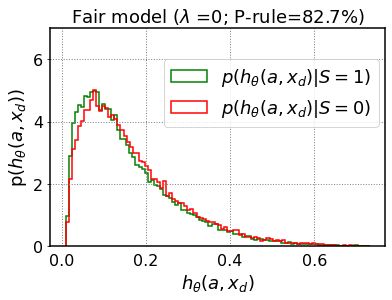

<Figure size 432x288 with 0 Axes>

In [ ]:
Ypredtest= torch.sigmoid(m_NN_y(torch.FloatTensor(df3.values).to(device))).cpu().data.numpy()
#Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
Ho = (S1_train==1)
Fe = (S1_train==0)
odds=(Ypredtest[Ho]>0.5).mean()/ (Ypredtest[Fe]>0.5).mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
#Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (2,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
#plt.rcParams["figure.figsize"] = (3,3)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax1.hist(Ypredtest[Ho], color = 'green',bins=100, density=1, histtype="step", label="$p(h_{\\theta}(a,x_{d})|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe], color = 'red',bins=100, density=1,histtype="step", label="$p(h_{\\theta}(a,x_{d})|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,7)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(a,x_{d})$", fontsize=18)
plt.ylabel("p($h_{\\theta}(a,x_{d})$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.66, 0.9),shadow=False, ncol=1, fontsize=18)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(lamb) + '; P-rule=' + str(round(PRULEtest*100,1)) +'%)', fontsize=18)
fig.savefig("Test_distrib25_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
fig.savefig("PG2015_MT_distrib_lam" + str(lamb)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
plt.show()
plt.clf()

0.8272682520005212


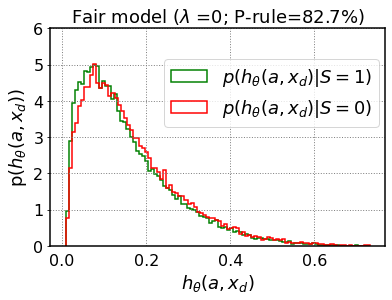

<Figure size 432x288 with 0 Axes>

In [ ]:
Ypredtest= torch.sigmoid(m_NN_y(torch.FloatTensor(df3.values).to(device))).cpu().data.numpy()
#Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
Ho = (S1_train==1)
Fe = (S1_train==0)
odds=(Ypredtest[Ho]>0.5).mean()/ (Ypredtest[Fe]>0.5).mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
#Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (2,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
#plt.rcParams["figure.figsize"] = (3,3)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax1.hist(Ypredtest[Ho], color = 'green',bins=100, density=1, histtype="step", label="$p(h_{\\theta}(a,x_{d})|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe], color = 'red',bins=100, density=1,histtype="step", label="$p(h_{\\theta}(a,x_{d})|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,6)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(a,x_{d})$", fontsize=18)
plt.ylabel("p($h_{\\theta}(a,x_{d})$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.66, 0.9),shadow=False, ncol=1, fontsize=18)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(0) + '; P-rule=' + str(round(PRULEtest*100,1)) +'%)', fontsize=18)
fig.savefig("Test_distrib25_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
fig.savefig("Test_distrib_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
plt.show()
plt.clf()

0.985191024892961


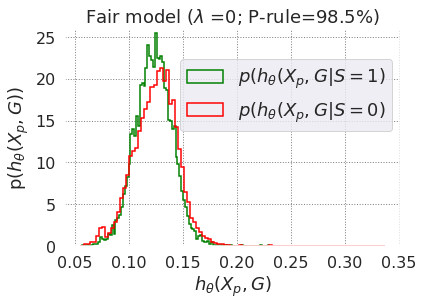

<Figure size 432x288 with 0 Axes>

In [ ]:
y_pred2= np.expand_dims(reg.predict(X_train),axis=1)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
Ho = (S1_test==1)
Fe = (S1_test==0)
odds=Ypredtest[Ho].mean()/ Ypredtest[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (2,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
#plt.rcParams["figure.figsize"] = (3,3)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax1.hist(Ypredtest[Ho ], color = 'green',bins=100, density=1, histtype="step", label="$p(h_{\\theta}(X_{p},G|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe ], color = 'red',bins=100, density=1,histtype="step", label="$p(h_{\\theta}(X_{p},G|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,26)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(X_{p},G)$", fontsize=18)
plt.ylabel("p($h_{\\theta}(X_{p},G)$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.66, 0.9),shadow=False, ncol=1, fontsize=18)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(0) + '; P-rule=' + str(round(PRULEtest*100,1)) +'%)', fontsize=18)
fig.savefig("Test_distrib25_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
fig.savefig("Test_distrib_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
plt.show()
plt.clf()

0.985191024892961


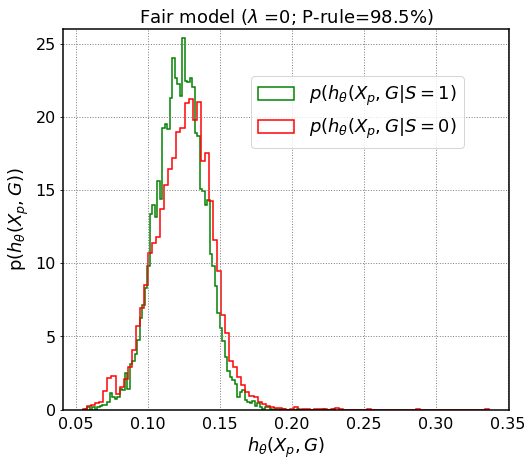

<Figure size 432x504 with 0 Axes>

In [ ]:
y_pred2= np.expand_dims(reg.predict(X_train),axis=1)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
Ho = (S1_test==1)
Fe = (S1_test==0)
odds=Ypredtest[Ho].mean()/ Ypredtest[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (2,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (6,7)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax1.hist(Ypredtest[Ho ], color = 'green',bins=100, density=1, histtype="step", label="$p(h_{\\theta}(X_{p},G|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe ], color = 'red',bins=100, density=1,histtype="step", label="$p(h_{\\theta}(X_{p},G|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,26)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(X_{p},G)$", fontsize=18)
plt.ylabel("p($h_{\\theta}(X_{p},G)$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.66, 0.9),shadow=False, ncol=1, fontsize=18)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(0) + '; P-rule=' + str(round(PRULEtest*100,1)) +'%)', fontsize=18)
fig.savefig("Test_distrib25_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
fig.savefig("Test_distrib_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
plt.show()
plt.clf()

0.985191024892961


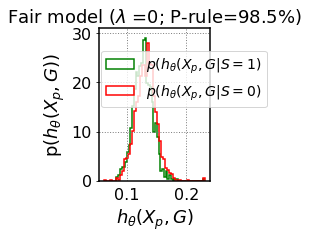

<Figure size 216x216 with 0 Axes>

In [ ]:
y_pred2= np.expand_dims(reg.predict(X_train),axis=1)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
Ho = (S1_test==1)
Fe = (S1_test==0)
odds=Ypredtest[Ho].mean()/ Ypredtest[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (3,3)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax1.hist(Ypredtest[Ho & (y_testt.squeeze(1)>=1)], color = 'green',bins=50, density=1, histtype="step", label="$p(h_{\\theta}(X_{p},G|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe & (y_testt.squeeze(1)>=1)], color = 'red',bins=50, density=1,histtype="step", label="$p(h_{\\theta}(X_{p},G|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,31)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(X_{p},G)$", fontsize=18)
plt.ylabel("p($h_{\\theta}(X_{p},G)$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.76, 0.9),shadow=False, ncol=1, fontsize=14)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(0) + '; P-rule=' + str(round(PRULEtest*100,1)) +'%)', fontsize=18)
fig.savefig("Test_distrib25_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
fig.savefig("Test_distrib_lam" + str(0)+ 'P-rule=' + str(round(PRULEtest*100,1)) + '.pdf')
plt.show()
plt.clf()

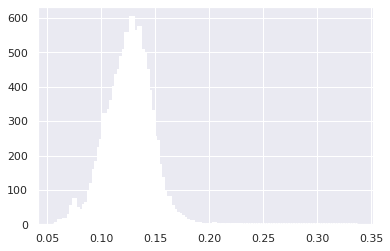

In [ ]:
_ = plt.hist(Ypredtest[Ho], bins='auto', lw=3, fc=(0, 0, 1, 0.5))
_ = plt.hist(Ypredtest[Fe], bins='auto', lw=3, fc=(1, 0, 0, 0.5))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


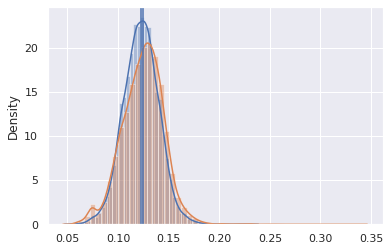

In [ ]:
import seaborn as sns, numpy as np
sns.set_theme(); np.random.seed(0)
ax = sns.distplot(Ypredtest[Ho],norm_hist=1)
plt.axvline(x=Ypredtest[Ho].mean())
ax = sns.distplot(Ypredtest[Fe],norm_hist=1)
plt.axvline(x=Ypredtest[Fe].mean())

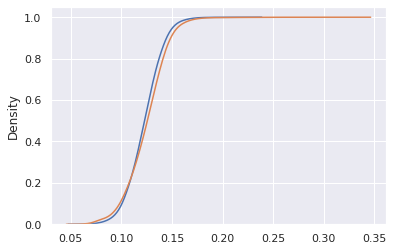

In [ ]:
import seaborn as sns, numpy as np
sns.set_theme(); np.random.seed(0)

ax = sns.kdeplot(Ypredtest[Ho].squeeze(1),cumulative=True)
ax = sns.kdeplot(Ypredtest[Fe].squeeze(1),cumulative=True)


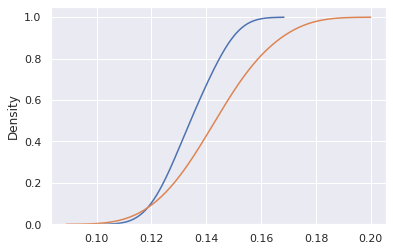

In [ ]:
import seaborn as sns, numpy as np
sns.set_theme(); np.random.seed(0)
ax = sns.kdeplot(Ypredtest[Ho & (y_testt.squeeze(1)==3)].squeeze(1),cumulative=True)
ax = sns.kdeplot(Ypredtest[Fe & (y_testt.squeeze(1)==3)].squeeze(1),cumulative=True)


In [ ]:
(y_testt.squeeze(1)>=3).mean()

0.0006604348709611867

In [ ]:
(y_testt==0).shape

(19684, 1)

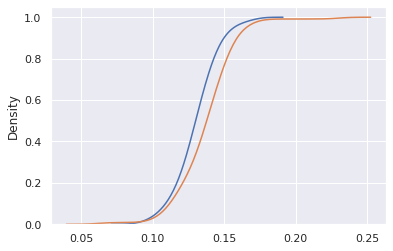

In [ ]:
import seaborn as sns, numpy as np
sns.set_theme(); np.random.seed(0)
ax = sns.kdeplot(Ypredtest[Ho & (y_testt.squeeze(1)==2)].squeeze(1),cumulative=True)
ax = sns.kdeplot(Ypredtest[Fe & (y_testt.squeeze(1)==2)].squeeze(1),cumulative=True)


In [ ]:
(y_testt.squeeze(1)>=2).mean()

0.010770168664905507

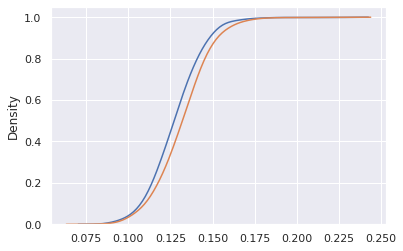

In [ ]:
import seaborn as sns, numpy as np
sns.set_theme(); np.random.seed(0)
ax = sns.kdeplot(Ypredtest[Ho & (y_testt.squeeze(1)==1)].squeeze(1),cumulative=True)
ax = sns.kdeplot(Ypredtest[Fe & (y_testt.squeeze(1)==1)].squeeze(1),cumulative=True)


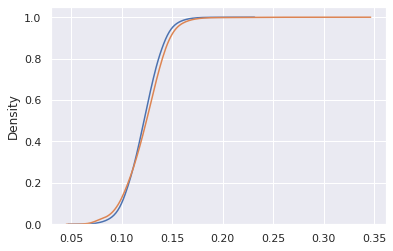

In [ ]:
import seaborn as sns, numpy as np
sns.set_theme(); np.random.seed(0)
ax = sns.kdeplot(Ypredtest[Ho & (y_testt.squeeze(1)==0)].squeeze(1),cumulative=True)
ax = sns.kdeplot(Ypredtest[Fe & (y_testt.squeeze(1)==0)].squeeze(1),cumulative=True)

In [ ]:

ax = sns.kdeplot(Ypredtest[Fe & (y_testt.squeeze(1)==1)].squeeze(1),cumulative=True)Ho.shape

(19684,)

In [ ]:
Ypredtest[Ho & (ytest==1)]

NameError: ignored

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=False, sharex=False)
g = sns.distplot(quotient, hist=True, label=protname, ax=ax1, rug=True)
ax1.set_title('basic distplot (kde=True)')
# get distplot line points
line = g.get_lines()[0]
xd = line.get_xdata()
yd = line.get_ydata()
# https://stackoverflow.com/questions/29661574/normalize-numpy-array-columns-in-python
def normalize(x):
    return (x - x.min(0)) / x.ptp(0)
#normalize points
yd2 = normalize(yd)
# plot them in another graph
ax.plot(xd, yd2)
ax.set_title('basic distplot (kde=True)\nwith normalized y plot values')

plt.show()

0.12276542506161808

PRICING NN

In [ ]:
!wget "https://raw.githubusercontent.com/vincent-grari/DIVERS/main/pricing_nn.py"

In [ ]:
from pricing_nn import Pricing_NN

In [ ]:
class NN_G(nn.Module):
    def __init__(self):
        super(NN_G, self).__init__()
        self.fc1 = nn.Linear(G_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, 1)        
    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        #x = F.dropout(x, p=0.2)
        h2 = torch.relu(self.fc2(h1))
        #x = F.dropout(x, p=0.2)
        h3 = torch.relu(self.fc3(h2))
        #x = F.dropout(x, p=0.2)
        h4 = self.fc4(h3)
        return h4

class NN_GLM(nn.Module):    
    def __init__(self):
        super(NN_GLM, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1]+1, 1)
    def forward(self, x,exposure):
        h1 = torch.exp(self.fc1(x))
        #h1 = self.fc1(x)+torch.log(exposure)
        return h1

In [ ]:
P1_NN = Pricing_NN(regressor="poisson",mod_h=NN_GLM,mod_g= NN_G, batch_size = 128,nbepoch = 1024, lr = 0.0001, p_device= 'cuda')

NameError: ignored

In [ ]:
from tqdm import tqdm 
from sklearn.utils import shuffle
from torch.autograd import Variable

In [ ]:
P1_NN.fit(X_train, y_train, G_train, E_train)

KeyboardInterrupt: ignored

In [ ]:
P1_NN.predict(X_train, G_train, E_train)

tensor([[0.1014],
        [0.0891],
        [0.1915],
        ...,
        [0.0919],
        [0.0723],
        [0.1909]], device='cuda:0', grad_fn=<ExpBackward>)

In [ ]:
P1_NN.predict_g(G_train)

tensor([[13.3409],
        [16.1719],
        [11.9487],
        ...,
        [15.3951],
        [18.2578],
        [16.0916]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
y_pred2= P1_NN.predict(X_train, G_train, E_train).cpu().data.numpy()
y_pred2t= P1_NN.predict(X_test, G_test, E_test).cpu().data.numpy()


In [ ]:
print(" GINI Poi without zonier via Reg : ", gini_coefficient(y_pred2))
print(" GINI Poi without zonier via Reg : ", gini_coefficient(y_pred2t))
print(" EDR POIS Poi without zonier via Reg : ", EDR_POIS(y_pred2,y_traint))
print(" EDR POIS Poi without zonier via Reg : ", EDR_POIS(y_pred2t,y_testt))
print(" MSE NN without zonier via Reg : ", np.mean((y_traint- y_pred2)**2))
print(" MSE NN without zonier via Reg : ", np.mean((y_testt- y_pred2t)**2))

 GINI Poi without zonier via Reg :  0.3190141080347123
 GINI Poi without zonier via Reg :  0.32111758773443716
 EDR POIS Poi without zonier via Reg :  0.08233498570906495
 EDR POIS Poi without zonier via Reg :  -0.08617379652934676
 MSE NN without zonier via Reg :  0.12984692163346045
 MSE NN without zonier via Reg :  0.13423445220097072


FAIR PRICING NN

In [ ]:
table = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

In [ ]:
lamb_HGR=0
table = np.vstack([table,[lamb_HGR,
                          gini_coefficient(y_pred2),
#                          gini_coefficient(y_pred2t),
                          EDR_POIS(y_pred2,y_traint),
 #                         EDR_POIS(y_pred2t,y_testt),
                          np.mean((y_traint- y_pred2)**2),
 #                         np.mean((y_testt- y_pred2t)**2),
                          p_rule(y_pred2,S1_train),
 #                         p_rule(y_pred2t,S1_test),
                          DispER(y_pred2 ,y_traint, S1_train),
 #                         DispER(y_pred2t ,y_testt, S1_test),
                          rdc(y_pred2, np.expand_dims(S1_train, axis=1)),
 #                         rdc(y_pred2t, np.expand_dims(S1_test, axis=1)),
                          #rdc(y_pred2, np.expand_dims(S2_train, axis=1)),
                          #rdc(y_pred2t, np.expand_dims(S2_test, axis=1)),
                          HGRNNTrain1,
                          #HGRNNTest1#,
                          #HGRNNTest2
                          rdc(y_pred2, np.expand_dims(S1_train, axis=1)),
                          ]])

ValueError: ignored

In [74]:
from tqdm import tqdm 
from sklearn.utils import shuffle
import numpy as np
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.autograd import Variable

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from tqdm import tqdm 

class Fair_Pricing_NN(torch.nn.Module): 

    def __init__(self,regressor, mod_h,mod_g,mod_v,lr,batch_size,p_device,nbepoch, lambdaHGR, nbepochHGR, start_epochHGR, mod_HGR_1,mod_HGR_2): 
        super().__init__()
        self.lr = lr
        self.batch_size = int(batch_size)
        self.device = torch.device(p_device)
        self.nbepoch = int(nbepoch)
        self.model_h = mod_h()
        self.model_g = mod_g()
        self.model_v = mod_v()
        self.lambdaHGR = lambdaHGR
        self.nbepochHGR = int(nbepochHGR)
        self.start_epochHGR= int(start_epochHGR)
        self.mod_HGR_1 = mod_HGR_1()
        self.mod_HGR_2 = mod_HGR_2()
        if regressor == 'poisson': 
          # Use Adam to fit the model 
          self.criterion = self.Poisson_Loss
        elif regressor == 'gamma': 
          self.criterion = self.Gamma_Loss
        elif regressor == 'logistic':
          self.criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
        else: 
          print('Le regressor est mal renseigné: ("poisson" ou "gamma")')
    def forward(self, x): 
        out = self.linear(x) 
        return out 

    def predict(self, X_train, G_train,  V_train, E_train): 
        e_var = torch.FloatTensor(np.expand_dims(E_train,axis = 1)).to(self.device)
        x_var = Variable(torch.FloatTensor(X_train.values)).to(self.device)
        g_out = self.predict_g(G_train)
        v_out = self.predict_v(V_train)
        yhat= self.model_h(torch.cat((x_var,g_out,v_out),1),e_var)
        return yhat

    def predict_g(self, G_train): 
        g_var = Variable((torch.FloatTensor(G_train.values))).to(self.device)
        g_out = self.model_g(g_var)
        return g_out

    def predict_v(self, V_train): 
        v_var = Variable((torch.FloatTensor(V_train.values))).to(self.device)
        v_out = self.model_v(v_var)
        return v_out

    def Poisson_Loss(self,yhat, y):
      #loss=torch.mean(torch.exp(xbeta)-y*xbeta)
      loss=torch.mean(yhat-y*torch.log(yhat))
      return loss
    
    def Gamma_Loss(self,yhat, y):
      #loss = torch.mean(yhat+(y-torch.log(yhat))/torch.log(yhat))
      loss = torch.mean(-torch.log(y/yhat)+(y-yhat)/yhat)
      return loss  
    
    def EDR_POIS(self, yhat, y):
    #loss=torch.mean(torch.exp(xbeta)-y*xbeta)
    #loss=torch.mean(yhat-y*torch.log(yhat))
      eps=0.000000000001
      res=1-np.mean((y*np.log((y+eps)/yhat)-(y-yhat)))/np.mean((y*np.log((y+eps)/np.mean(y))))
      return res
    
    def EDR_GAMMA(yhat, y):
      #loss=torch.mean(torch.exp(xbeta)-y*xbeta)
      #loss=torch.mean(yhat-y*torch.log(yhat))
      eps=0.000000000001
      res=1-np.mean(-np.log(y/yhat)+(y-yhat)/yhat)/np.mean(-np.log(y/np.mean(y))+(y-np.mean(y))/np.mean(y))
      return res

    def fit(self, X_train, y_train, G_train, V_train, E_train, S_train): 
        batch_no = len(X_train) // self.batch_size
        ##### PREDICTOR H #####
        #self.model_h=NN_POISS()
        #criterion = nn.PoissonNLLLoss()
 
        #criterion = self.Poisson_Loss
        #, eps=1e-8) #torch.nn.MSELoss() #reduction='mean'
        optimizer_h = torch.optim.Adam(self.model_h.parameters(), lr=self.lr)
        self.model_h.to(self.device)

        ##### PREDICTOR G #####
        #self.model_g=NN_G()
        #criterion = torch.nn.MSELoss() #reduction='mean'
        optimizer_g = torch.optim.Adam(self.model_g.parameters(), lr=self.lr)
        self.model_g.to(self.device)


        optimizer_v = torch.optim.Adam(self.model_v.parameters(), lr=self.lr)
        self.model_v.to(self.device)

        ##### PREDICTOR HGR #####
        #self.model_g=NN_G()
        #criterion = torch.nn.MSELoss() #reduction='mean'
        optimizer_HGR_1 = torch.optim.Adam(self.mod_HGR_1.parameters(), lr=self.lr)
        self.mod_HGR_1.to(self.device)
        optimizer_HGR_2 = torch.optim.Adam(self.mod_HGR_2.parameters(), lr=self.lr)
        self.mod_HGR_2.to(self.device)
        epsilon = 0.000000001
        for epoch in tqdm(range(1, self.nbepoch + 1), 'Epoch: ', leave=False):
            x_train, ytrain, g_train, v_train, e_train, s_train = shuffle(X_train.values,np.expand_dims(y_train,axis = 1),G_train.values, V_train.values, np.expand_dims(E_train,axis = 1),np.expand_dims(S_train,axis = 1))
            # Mini batch learning
            for i in range(batch_no):
                start = i * self.batch_size
                end = start + self.batch_size
                g_var = Variable(torch.FloatTensor(g_train[start:end])).to(self.device)
                v_var = Variable(torch.FloatTensor(v_train[start:end])).to(self.device)
                e_var = Variable(torch.FloatTensor(e_train[start:end])).to(self.device)
                s_var = Variable(torch.FloatTensor(s_train[start:end])).to(self.device)
                x_var = Variable(torch.FloatTensor(x_train[start:end])).to(self.device)
                y_var = Variable(torch.FloatTensor(ytrain[start:end])).to(self.device)
                # Forward + Backward + Optimize

                g_out = self.model_g(g_var)
                v_out = self.model_v(v_var)
                ypred_var= self.model_h(torch.cat((x_var,g_out,v_out),1),e_var)
                ypred_var0 = ypred_var.detach()
                if epoch >=self.start_epochHGR: 
                  for k in range(self.nbepochHGR) :
                    optimizer_HGR_1.zero_grad()
                    optimizer_HGR_2.zero_grad()

                    pred_F = self.mod_HGR_1(s_var.detach().to(self.device))
                    pred_G = self.mod_HGR_2(ypred_var0.to(self.device))
                    pred_F_norm = (pred_F - torch.mean(pred_F)) / torch.sqrt((torch.std(pred_F).pow(2) + epsilon))
                    pred_G_norm = (pred_G - torch.mean(pred_G)) / torch.sqrt((torch.std(pred_G).pow(2) + epsilon))

                    ret = torch.mean(pred_F_norm * pred_G_norm)
                    loss_HGR = - ret  # maximize
                    loss_HGR.backward()

                    optimizer_HGR_1.step()
                    optimizer_HGR_2.step()

                optimizer_v.zero_grad()
                optimizer_g.zero_grad()
                optimizer_h.zero_grad()
                g_out = self.model_g(g_var)
                v_out = self.model_v(v_var)
                ypred_var= self.model_h(torch.cat((x_var,g_out,v_out),1),e_var)
                #ypred_var= model_h(x_var,e_var)
                #loss = F.poisson_nll_loss(ypred_var, y_var, reduction='none') 
                #loss = torch.mean(loss)
                pred_F = self.mod_HGR_1(s_var.detach().cuda())
                pred_G = self.mod_HGR_2(ypred_var)
                pred_F_norm = (pred_F - torch.mean(pred_F)) / torch.sqrt((torch.std(pred_F).pow(2) + epsilon))
                pred_G_norm = (pred_G - torch.mean(pred_G)) / torch.sqrt((torch.std(pred_G).pow(2) + epsilon))
                ret = torch.mean(pred_F_norm * pred_G_norm)
                loss = self.criterion(ypred_var, y_var)
                if epoch >=self.start_epochHGR: 
                  loss = self.criterion(ypred_var, y_var) + self.lambdaHGR*ret
                loss.backward()
                optimizer_h.step()
                optimizer_g.step()
                optimizer_v.step()  
          
                #print(epoch) 
                #print(ypred_var)
                if epoch >=self.start_epochHGR:   
                  print(ret)   
            #print('EDR',loss)
            #print(" FairQuant train : ", FairQuant(ypred_var.cpu().data.numpy().squeeze(1) ,y_var.cpu().data.numpy().squeeze(1), s_var.cpu().data.numpy().squeeze(1)))
            print(" ACC : ",accuracy_score(y_var.cpu().data.numpy().squeeze(1), ypred_var.cpu().data.numpy().squeeze(1)>0.5))
            print(" P-rule : ",p_rule(ypred_var.cpu().data.numpy().squeeze(1), s_var.cpu().data.numpy().squeeze(1)))

        yhat = self.predict(X_train, G_train, V_train, E_train).cpu().data.numpy()
        #print(yhat.shape)
        #print(y_train.shape)
        return print('DONE')

In [ ]:
class NN_G(nn.Module):
    def __init__(self):
        super(NN_G, self).__init__()
        self.fc1 = nn.Linear(G_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, 1)        
    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        #x = F.dropout(x, p=0.2)
        h2 = torch.relu(self.fc2(h1))
        #x = F.dropout(x, p=0.2)
        h3 = torch.relu(self.fc3(h2))
        #x = F.dropout(x, p=0.2)
        h4 = self.fc4(h3)
        return h4

class NN_V(nn.Module):
    def __init__(self):
        super(NN_V, self).__init__()
        self.fc1 = nn.Linear(V_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, 1)        
    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        #x = F.dropout(x, p=0.2)
        h2 = torch.relu(self.fc2(h1))
        #x = F.dropout(x, p=0.2)
        h3 = torch.relu(self.fc3(h2))
        #x = F.dropout(x, p=0.2)
        h4 = self.fc4(h3)
        return h4

class NN_GLM3(nn.Module):    
    def __init__(self):
        super(NN_GLM3, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1]+2, 1)
    def forward(self, x,exposure):
        h1 = torch.exp(self.fc1(x)+torch.log(exposure))
        #h1 = self.fc1(x)+torch.log(exposure)
        return h1

class NN_GLM(nn.Module):
    def __init__(self):
        super(NN_GLM, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1]+2, 1)
    def forward(self, x,exposure):
        #h1 = torch.exp(self.fc1(x))
        h1 = self.fc1(x)
        #h1 = self.fc1(x)+torch.log(exposure)
        return h1

In [78]:
lamb_HGR=0
P1_NN = Fair_Pricing_NN(regressor="gamma",mod_h=NN_GLM,mod_g= NN_G,mod_v= NN_V, batch_size = 256,nbepoch = 2, lr = 0.0001, p_device= 'cuda', lambdaHGR=lamb_HGR, nbepochHGR=1, start_epochHGR=250, mod_HGR_1=Net_HGR,mod_HGR_2= Net2_HGR)

NameError: ignored

In [ ]:
P1_NN.fit(X_train, y_train, G_train, V_train, E_train, S1_train)

Epoch:  50%|█████     | 1/2 [00:02<00:02,  2.34s/it]

 ACC :  0.7734375
 P-rule :  83.33333333333334


 ACC :  0.75
 P-rule :  52.48081841432225
DONE


In [77]:
#y_pred2=P1_NN.predict(X_train,G_train,E_train).cpu().data.numpy()
y_pred2= P1_NN.predict(X_train, G_train, V_train, E_train).cpu().data.numpy()
g_pred2= P1_NN.predict_g(G_train).cpu().data.numpy()
v_pred2= P1_NN.predict_v(V_train).cpu().data.numpy()
print(" RDC YPRED & S1 test :",     rdc(y_pred2, np.expand_dims(S1_train, axis=1)))
print(" RDC ZON & S1 test :  ",     rdc(np.expand_dims(g_pred2, axis=1), np.expand_dims(S1_train, axis=1)))
print(" RDC YPRED & AGE test : ",   rdc(y_pred2, np.expand_dims(df3[0], axis=1)))
print(" RDC YPRED & COUL test : ",  rdc(y_pred2, np.expand_dims(df3[1], axis=1)))
print(" RDC YPRED & ZON test : ",   rdc(y_pred2, np.expand_dims(df3[2], axis=1)))
print(" RDC YPRED & SALARY test : ",rdc(y_pred2, np.expand_dims(G_train, axis=1)))
print(" RDC YPRED & VEH test : ",   rdc(y_pred2, np.expand_dims(v_pred2, axis=1)))
print(" RDC VEH & S1 test : ",      rdc(np.expand_dims(S1_train, axis=1), np.expand_dims(v_pred2, axis=1)))
#print(" RDC VEH & A train : ",     rdc(np.expand_dims(A_train, axis=1), np.expand_dims(v_pred2, axis=1)))
print(" P-rule : ",p_rule(y_pred2,np.expand_dims(S1_train,1)))
print(" GINI Train : ", gini_coefficient(y_pred2))
#print(" GINI Test : ", gini_coefficient(y_pred2t))
print(" EDR Train : ", EDR_GAMMA(y_pred2,y_traint))
#print(" EDR Test : ", EDR_POIS(y_pred2t,y_testt))
print(" MSE Train : ", np.mean((y_traint- y_pred2)**2))
#print(" MSE Test : ", np.mean((y_testt- y_pred2t)**2))
#print(" DispER test : ",  DispER(y_pred2t,y_testt,S1_test))
print(" FairQuant train : ", FairQuant(y_pred2.squeeze(1) ,y_traint.squeeze(1), S1_train))
#print(" FairQuant test : ", FairQuant(y_pred2t.squeeze(1) ,y_testt.squeeze(1), S1_test))
print(" RDC S1 train : ", rdc(y_pred2, np.expand_dims(S1_train, axis=1)))
print(" FairQuant train Y0: ", FairQuant(y_pred2[y_traint==0] ,y_traint[y_traint==0], S1_train[y_traint.squeeze(1)==0]))
print(" RDC S1 train Y0: ", rdc(y_pred2[y_traint==0], np.expand_dims(S1_train[y_traint.squeeze(1)==0], axis=1)))

print(" FairQuant train Y1: ", FairQuant(y_pred2[y_traint==1] ,y_traint[y_traint==1], S1_train[y_traint.squeeze(1)==1]))
print(" RDC S1 train Y1: ", rdc(y_pred2[y_traint==1], np.expand_dims(S1_train[y_traint.squeeze(1)==1], axis=1)))

print(" FairQuant train Y2: ", FairQuant(y_pred2[y_traint>1] ,y_traint[y_traint>1], S1_train[y_traint.squeeze(1)>1]))
print(" RDC S1 train Y2: ", rdc(y_pred2[y_traint>1], np.expand_dims(S1_train[y_traint.squeeze(1)>1], axis=1)))


NameError: ignored

In [ ]:
print(" P-rule : ", p_rule(y_pred2,np.expand_dims(S1_train,1)))
print(" ACC : ", accuracy_score(y_train, y_pred2>0.5))

 P-rule :  85.84065497953006
 ACC :  0.8427439512097581


In [ ]:
y_pred2

array([[0.28769627],
       [0.32592085],
       [0.09205192],
       ...,
       [0.38910222],
       [0.08026942],
       [0.515772  ]], dtype=float32)

 P-rule :  63.95882533506948
 ACC :  0.793125


In [ ]:
def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) * 100

In [ ]:
def DispFNR(y_pred, y, z_values, threshold=0.5):
    ypred_z_1 = y_pred > threshold if threshold else y_pred[z_values == 1]
    ypred_z_0 = y_pred > threshold if threshold else y_pred[z_values == 0]
    result=abs(ypred_z_1[(y==1) & (z_values==0)].mean()-ypred_z_1[(y==1) & (z_values==1)].mean())
    return result
def DispFPR(y_pred, y, z_values, threshold=0.5):
    ypred_z_1 = y_pred > threshold if threshold else y_pred[z_values == 1]
    ypred_z_0 = y_pred > threshold if threshold else y_pred[z_values == 0]
    result=abs(ypred_z_1[(y==0) & (z_values==0)].mean()-ypred_z_1[(y==0) & (z_values==1)].mean())
    return result


In [ ]:
!wget "http://grarivincent.com/research/rdc.py"
from rdc import rdc

--2021-10-18 11:00:40--  http://grarivincent.com/research/rdc.py
Resolving grarivincent.com (grarivincent.com)... 217.160.0.183, 2001:8d8:100f:f000::2ce
Connecting to grarivincent.com (grarivincent.com)|217.160.0.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2782 (2.7K) [text/html]
Saving to: ‘rdc.py’

rdc.py              100%[===================>]   2.72K  --.-KB/s    in 0s      

2021-10-18 11:00:40 (343 MB/s) - ‘rdc.py’ saved [2782/2782]



In [ ]:

class HGR_NN(nn.Module):

    def __init__(self, model_F, model_G):
        super(HGR_NN, self).__init__()
        self.mF = model_F
        self.mG = model_G
        self.optimizer_F = torch.optim.Adam(self.mF.parameters(), lr=0.001)
        self.optimizer_G = torch.optim.Adam(self.mG.parameters(), lr=0.001)

    def forward(self, yhat, y2_var, nb):
        for j in range(nb):
            pred_F = self.mF(yhat.detach())
            pred_G = self.mG(y2_var.detach())

            epsilon = 0.0001
            pred_F_norm = (pred_F - torch.mean(pred_F)) / torch.sqrt((torch.std(pred_F).pow(2) + epsilon))
            pred_G_norm = (pred_G - torch.mean(pred_G)) / torch.sqrt((torch.std(pred_G).pow(2) + epsilon))
            pred_F_norm[torch.isnan(pred_F_norm)] = 0
            pred_G_norm[torch.isnan(pred_G_norm)] = 0

            ret = torch.mean(pred_F_norm * pred_G_norm)
            loss = - ret  # maximize
            self.mF.zero_grad()
            self.mG.zero_grad()
            loss.backward()
            # print(loss)
            self.optimizer_F.step()
            self.optimizer_G.step()

        return ret



In [ ]:
def DispER(y_pred, y, z_values, threshold=0.5):
    RES=(y_pred-y)
    RES_1 = RES[z_values == 1]
    RES_0 = RES[z_values == 0]
    odds = np.abs(RES_1.mean() / RES_0.mean())
    return np.min([odds, 1/odds]) * 100

0.7873984


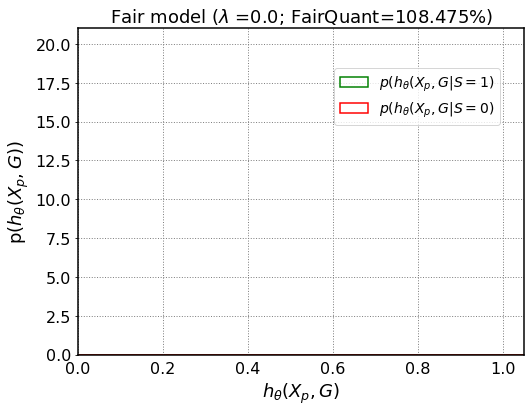

<Figure size 576x432 with 0 Axes>

In [ ]:
y_pred2= P1_NN.predict(X_train, G_train, E_train).cpu().data.numpy()
y_pred2t= P1_NN.predict(X_test, G_test, E_test).cpu().data.numpy()

Ypredtest= y_pred2t
Ho = (S1_test==1)
Fe = (S1_test==0)
odds=Ypredtest[Ho].mean()/ Ypredtest[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
#Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (3,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax1.hist(Ypredtest[Ho], color = 'green',bins=150, density=1, histtype="step", label="$p(h_{\\theta}(X_{p},G|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe], color = 'red',bins=150, density=1,histtype="step", label="$p(h_{\\theta}(X_{p},G|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,21)
plt.xlim(0,1.05)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(X_{p},G)$", fontsize=18)
plt.ylabel("p($h_{\\theta}(X_{p},G)$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.76, 0.9),shadow=False, ncol=1, fontsize=14)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(lamb_HGR) + '; FairQuant=' + str(round(FairQuant(y_pred2t.squeeze(1) ,y_testt.squeeze(1), S1_test)[0]*100,3)) +'%)', fontsize=18)
fig.savefig("DP_Test_distrib_lam" + str(lamb_HGR)+ 'FairQuant=' + str(round(FairQuant(y_pred2t.squeeze(1) ,y_testt.squeeze(1), S1_test)[0]*100,3)) + '.pdf')
plt.show()
plt.clf()

0.7873984


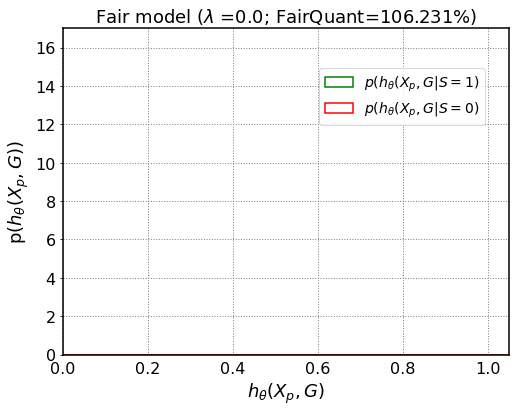

<Figure size 576x432 with 0 Axes>

In [ ]:
y_pred2= P1_NN.predict(X_train, G_train, E_train).cpu().data.numpy()
y_pred2t= P1_NN.predict(X_test, G_test, E_test).cpu().data.numpy()

Ypredtest= y_pred2t
Ho = (S1_test==1)
Fe = (S1_test==0)
odds=Ypredtest[Ho].mean()/ Ypredtest[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
#Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (3,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
Filtre = (y_testt.squeeze(1)==0)
ax1.hist(Ypredtest[Ho & (Filtre)], color = 'green',bins=50, density=1, histtype="step", label="$p(h_{\\theta}(X_{p},G|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe & (Filtre)], color = 'red',bins=50, density=1,histtype="step", label="$p(h_{\\theta}(X_{p},G|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,17)
plt.xlim(0,1.05)

#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(X_{p},G)$", fontsize=18)
plt.ylabel("p($h_{\\theta}(X_{p},G)$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.76, 0.9),shadow=False, ncol=1, fontsize=14)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(lamb_HGR) + '; FairQuant=' + str(round(FairQuant(y_pred2t[Filtre].squeeze(1),y_testt[Filtre].squeeze(1), S1_test[Filtre])[0]*100,3)) +'%)', fontsize=18)
fig.savefig("DP0_Test_distrib_lam" + str(lamb_HGR)+ 'FairQuant=' + str(round(FairQuant(y_pred2t[Filtre].squeeze(1),y_testt[Filtre].squeeze(1), S1_test[Filtre])[0]*100,3)) + '.pdf')
plt.show()
plt.clf()

0.84602416


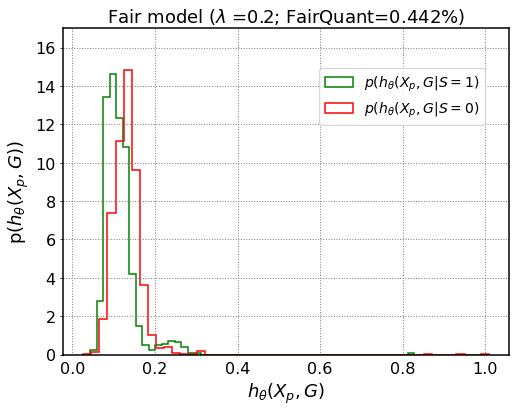

<Figure size 576x432 with 0 Axes>

In [ ]:
y_pred2= P1_NN.predict(X_train, G_train, E_train).cpu().data.numpy()
y_pred2t= P1_NN.predict(X_test, G_test, E_test).cpu().data.numpy()

Ypredtest= y_pred2t
Ho = (S1_test==1)
Fe = (S1_test==0)
odds=Ypredtest[Ho].mean()/ Ypredtest[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
#Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (3,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
Filtre = (y_testt.squeeze(1)==1)
ax1.hist(Ypredtest[Ho & (Filtre)], color = 'green',bins=50, density=1, histtype="step", label="$p(h_{\\theta}(X_{p},G|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe & (Filtre)], color = 'red',bins=50, density=1,histtype="step", label="$p(h_{\\theta}(X_{p},G|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,17)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(X_{p},G)$", fontsize=18)
plt.ylabel("p($h_{\\theta}(X_{p},G)$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.76, 0.9),shadow=False, ncol=1, fontsize=14)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(lamb_HGR) + '; FairQuant=' + str(round(FairQuant(y_pred2t[Filtre].squeeze(1),y_testt[Filtre].squeeze(1), S1_test[Filtre])[0]*100,3)) +'%)', fontsize=18)
fig.savefig("DP1_Test_distrib_lam" + str(lamb_HGR)+ 'FairQuant=' + str(round(FairQuant(y_pred2t[Filtre].squeeze(1),y_testt[Filtre].squeeze(1), S1_test[Filtre])[0]*100,3)) + '.pdf')
plt.show()
plt.clf()

0.84602416


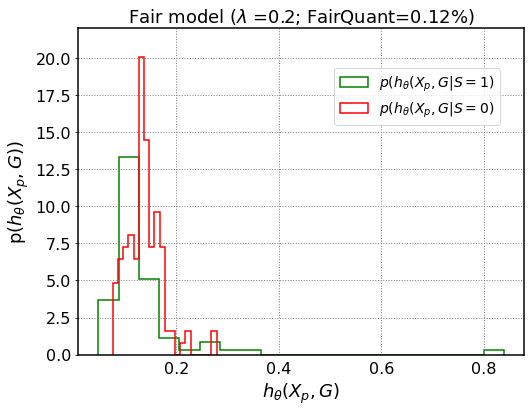

<Figure size 576x432 with 0 Axes>

In [ ]:
y_pred2= P1_NN.predict(X_train, G_train, E_train).cpu().data.numpy()
y_pred2t= P1_NN.predict(X_test, G_test, E_test).cpu().data.numpy()

Ypredtest= y_pred2t
Ho = (S1_test==1)
Fe = (S1_test==0)
odds=Ypredtest[Ho].mean()/ Ypredtest[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
#Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (3,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
Filtre = (y_testt.squeeze(1)>=2)
ax1.hist(Ypredtest[Ho & (Filtre)], color = 'green',bins=20, density=1, histtype="step", label="$p(h_{\\theta}(X_{p},G|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe & (Filtre)], color = 'red',bins=20, density=1,histtype="step", label="$p(h_{\\theta}(X_{p},G|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,22)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(X_{p},G)$", fontsize=18)
plt.ylabel("p($h_{\\theta}(X_{p},G)$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.76, 0.9),shadow=False, ncol=1, fontsize=14)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(lamb_HGR) + '; FairQuant=' + str(round(FairQuant(y_pred2t[Filtre].squeeze(1),y_testt[Filtre].squeeze(1), S1_test[Filtre])[0]*100,3)) +'%)', fontsize=18)
fig.savefig("DP2_Test_distrib_lam" + str(lamb_HGR)+ 'FairQuant=' + str(round(FairQuant(y_pred2t[Filtre].squeeze(1),y_testt[Filtre].squeeze(1), S1_test[Filtre])[0]*100,3)) + '.pdf')
plt.show()
plt.clf()

In [ ]:
y_pred2= P1_NN.predict(X_train, G_train, E_train).cpu().data.numpy()
y_pred2t= P1_NN.predict(X_test, G_test, E_test).cpu().data.numpy()

print(" GINI Train : ", gini_coefficient(y_pred2))
print(" GINI Test : ", gini_coefficient(y_pred2t))
print(" EDR Train : ", EDR_POIS(y_pred2,y_traint))
print(" EDR Test : ", EDR_POIS(y_pred2t,y_testt))
print(" MSE Train : ", np.mean((y_traint- y_pred2)**2))
print(" MSE Test : ", np.mean((y_testt- y_pred2t)**2))
#print(" Prule train : ", p_rule(y_pred2,S1_train))
#print(" Prule test : ",  p_rule(y_pred2t,S1_test))
print(" DispER train : ", DispER(y_pred2 ,y_traint, S1_train))
print(" DispER test : ",  DispER(y_pred2t,y_testt,S1_test))
print(" FairQuant train : ", FairQuant(y_pred2.squeeze(1) ,y_traint.squeeze(1), S1_train))
print(" FairQuant test : ", FairQuant(y_pred2t.squeeze(1) ,y_testt.squeeze(1), S1_test))
print(" RDC S1 train : ", rdc(y_pred2, np.expand_dims(S1_train, axis=1)))
print(" RDC S1 test : ",  rdc(y_pred2t, np.expand_dims(S1_test, axis=1)))
print(" RDC S2 train : ", rdc(y_pred2, np.expand_dims(S2_train, axis=1)))
print(" RDC S2 test : ",  rdc(y_pred2t, np.expand_dims(S2_test, axis=1)))
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTrain1=HGR_NNP(torch.FloatTensor(y_pred2) , torch.FloatTensor(np.expand_dims(S1_train,axis=1)) ,500).cpu().data.numpy()
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTest1=HGR_NNP(torch.FloatTensor(y_pred2t) , torch.FloatTensor(np.expand_dims(S1_test,axis=1)) ,500).cpu().data.numpy()
print(" HGR S1 train : ", HGRNNTrain1)
print(" HGR S1 test : ",  HGRNNTest1)
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTrain2=HGR_NNP(torch.FloatTensor(y_pred2) , torch.FloatTensor(np.expand_dims(S2_train,axis=1)) ,500).cpu().data.numpy()
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
HGRNNTest2=HGR_NNP(torch.FloatTensor(y_pred2t) , torch.FloatTensor(np.expand_dims(S2_test,axis=1)) ,500).cpu().data.numpy()
print(" HGR S2 train : ", HGRNNTrain2)
print(" HGR S2 test : ",  HGRNNTrain2)
g_pred2= P1_NN.predict_g(G_train).cpu().data.numpy()
g_pred2t= P1_NN.predict_g(G_test).cpu().data.numpy()
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
G_HGRNNTrain2=HGR_NNP(torch.FloatTensor(g_pred2) , torch.FloatTensor(np.expand_dims(S1_train,axis=1)) ,500).cpu().data.numpy()
HGR_NNP = HGR_NN(Net_HGR(),Net2_HGR())
G_HGRNNTest2=HGR_NNP(torch.FloatTensor(g_pred2t) , torch.FloatTensor(np.expand_dims(S1_test,axis=1)) ,500).cpu().data.numpy()
print(" G HGR S2 train : ", G_HGRNNTrain2)
print(" G HGR S2 test : ",  G_HGRNNTest2)
table = np.vstack([table,[lamb_HGR,
                          gini_coefficient(y_pred2),
                          gini_coefficient(y_pred2t),
                          EDR_POIS(y_pred2,y_traint),
                          EDR_POIS(y_pred2t,y_testt),
                          np.mean((y_traint- y_pred2)**2),
                          np.mean((y_testt- y_pred2t)**2),
                          FairQuant(y_pred2.squeeze(1) ,y_traint.squeeze(1), S1_train)[0],
                          FairQuant(y_pred2t.squeeze(1) ,y_testt.squeeze(1), S1_test)[0],
                          rdc(y_pred2, np.expand_dims(S1_train, axis=1)),
                          rdc(y_pred2t, np.expand_dims(S1_test, axis=1)),
                          rdc(y_pred2, np.expand_dims(S2_train, axis=1)),
                          rdc(y_pred2t, np.expand_dims(S2_test, axis=1)),
                          G_HGRNNTrain2,
                          G_HGRNNTest2,
                          HGRNNTrain1,
                          HGRNNTest1,
                          HGRNNTest2
                          ]])
np.savetxt('table.out', table) 

 GINI Train :  0.9998031912570161
 GINI Test :  0.9998528214598431
 EDR Train :  -15.791232033695813
 EDR Test :  -75.78068191347722
 MSE Train :  306869.12003135274
 MSE Test :  2937552.8769715778
 DispER train :  1.1589020053946675
 DispER test :  78.6045074316304
 FairQuant train :  (1.172772216796875, 2.292324454151094)
 FairQuant test :  (1.084749984741211, 1.9611375489934288)
 RDC S1 train :  0.025082923683455584
 RDC S1 test :  0.026659801321256425
 RDC S2 train :  0.2719625771423076
 RDC S2 test :  0.27409142426491917
 HGR S1 train :  -0.0041767904
 HGR S1 test :  0.0013449985
 HGR S2 train :  0.0
 HGR S2 test :  0.0
 G HGR S2 train :  0.0035133488
 G HGR S2 test :  0.000788069


In [ ]:
table=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
table

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0.32766944229283845, 0.32975697079820165, 0.08835582450161972,
        -0.12279924423220279, 0.12941552633531944, 0.13423799231587527,
        (0.0003931894898414612, 2.576632915363142e-07),
        (0.0004587247967720032, 3.507140652891927e-07),
        0.0737482527641285, 0.07245224579319033, 0.05995347620919218,
        0.0752604165250205, array(0.00826486, dtype=float32),
        array(0.00600263, dtype=float32),
        array(0.08493204, dtype=float32),
        array(0.08092179, dtype=float32), array(0., dtype=float32)]],
      dtype=object)

In [ ]:
len([lamb_HGR,
                          gini_coefficient(y_pred2),
                          gini_coefficient(y_pred2t),
                          EDR_POIS(y_pred2,y_traint),
                          EDR_POIS(y_pred2t,y_testt),
                          np.mean((y_traint- y_pred2)**2),
                          np.mean((y_testt- y_pred2t)**2),
                          FairQuant(y_pred2.squeeze(1) ,y_traint.squeeze(1), S1_train),
                          FairQuant(y_pred2t.squeeze(1) ,y_testt.squeeze(1), S1_test),
                          rdc(y_pred2, np.expand_dims(S1_train, axis=1)),
                          rdc(y_pred2t, np.expand_dims(S1_test, axis=1)),
                          rdc(y_pred2, np.expand_dims(S2_train, axis=1)),
                          rdc(y_pred2t, np.expand_dims(S2_test, axis=1)),
                          G_HGRNNTrain2,
                          G_HGRNNTest2,
                          HGRNNTrain1,
                          HGRNNTest1,
                          HGRNNTest2
                          ])


18

In [ ]:
table=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

0.98029333


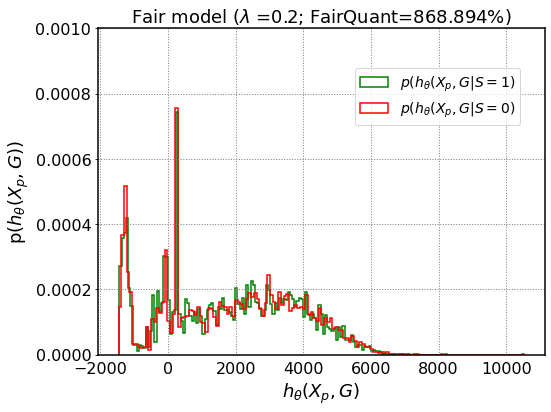

<Figure size 576x432 with 0 Axes>

In [ ]:
y_pred2= P1_NN.predict_g(G_train).cpu().data.numpy()
y_pred2t= P1_NN.predict_g(G_test).cpu().data.numpy()

Ypredtest= y_pred2t
Ho = (S1_test==1)
Fe = (S1_test==0)
odds=Ypredtest[Ho].mean()/ Ypredtest[Fe].mean()
PRULEtest= min(odds, 1/odds)
print(PRULEtest)
#Ypredtest= np.expand_dims(reg.predict(X_test),axis=1)
#plt.
from matplotlib.pyplot import figure
#figure(num=None, figsize=(2, 3), dpi=80, facecolor='w', edgecolor='k')
fig, ax1 = plt.subplots()
ax1.tick_params(  bottom = False, top = False)
#ax1.axes.yaxis.set_ticks(bottom = False)
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (3,2.8)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(1.5)
ax1.set_ylim( bottom = False)
#ax1.axes.xaxis.set_ticks([])
#ax1.axes.yaxis.set_ticks([])
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["font.size"] = 18.0
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax1.hist(Ypredtest[Ho], color = 'green',bins=150, density=1, histtype="step", label="$p(h_{\\theta}(X_{p},G|S=1)$",linewidth=1.5)
ax1.hist(Ypredtest[Fe], color = 'red',bins=150, density=1,histtype="step", label="$p(h_{\\theta}(X_{p},G|S=0)$",linewidth=1.5)
leg = plt.legend(loc="best", edgecolor="white",facecolor="white")
plt.ylim(0,0.001)
#plt.xlim(0,1.05)
#ax1.spines['top'].set_visible(False)
#ax1.spines['bottom'].set_visible(False)
#ax1.spines['right'].set_visible(False)
#ax1.spines['left'].set_visible(False)
plt.xlabel("$h_{\\theta}(X_{p},G)$", fontsize=18)
plt.ylabel("p($h_{\\theta}(X_{p},G)$)", fontsize=18)
plt.legend(loc="upper left")
plt.savefig("f-plain.pdf")
plt.legend(loc='upper center', bbox_to_anchor=(0.76, 0.9),shadow=False, ncol=1, fontsize=14)
#plt.show()
plt.title('Fair model ($\lambda$ =' + str(lamb_HGR) + '; FairQuant=' + str(round(FairQuant(y_pred2t.squeeze(1) ,y_testt.squeeze(1), S1_test)[0]*100,3)) +'%)', fontsize=18)
fig.savefig("DP_G_Test_distrib_lam" + str(lamb_HGR)+ 'FairQuant=' + str(round(FairQuant(y_pred2t.squeeze(1) ,y_testt.squeeze(1), S1_test)[0]*100,3)) + '.pdf')
plt.show()
plt.clf()

In [ ]:
from tqdm import tqdm 
from sklearn.utils import shuffle
import numpy as np
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.autograd import Variable

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from tqdm import tqdm 

class Fair_Pricing_NN(torch.nn.Module): 

    def __init__(self,regressor, mod_h,mod_g,lr,batch_size,p_device,nbepoch, lambdaHGR, nbepochHGR, start_epochHGR, mod_HGR_1,mod_HGR_2): 
        super().__init__()
        self.lr = lr
        self.batch_size = int(batch_size)
        self.device = torch.device(p_device)
        self.nbepoch = int(nbepoch)
        self.model_h = mod_h()
        self.model_g = mod_g()
        self.lambdaHGR = lambdaHGR
        self.nbepochHGR = int(nbepochHGR)
        self.start_epochHGR= int(start_epochHGR)
        self.mod_HGR_1 = mod_HGR_1()
        self.mod_HGR_2 = mod_HGR_2()
        if regressor == 'poisson': 
          # Use Adam to fit the model 
          self.criterion = self.Poisson_Loss
        elif regressor == 'gamma': 
          self.criterion = self.Gamma_Loss
        elif regressor == 'logistic':
          self.criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
        else: 
          print('Le regressor est mal renseigné: ("poisson" ou "gamma")')
    def forward(self, x): 
        out = self.linear(x) 
        return out 

    def predict(self, X_train,G_train,E_train): 
        e_var = torch.FloatTensor(np.expand_dims(E_train,axis = 1)).to(self.device)
        x_var = Variable(torch.FloatTensor(X_train.values)).to(self.device)
        g_out = self.predict_g(G_train)
        yhat= self.model_h(torch.cat((x_var,g_out),1),e_var)
        return yhat

    def predict_g(self, G_train): 
        g_var = Variable((torch.FloatTensor(G_train.values))).to(self.device)
        g_out = self.model_g(g_var)
        return g_out


    def Poisson_Loss(self,yhat, y):
      #loss=torch.mean(torch.exp(xbeta)-y*xbeta)
      loss=torch.mean(yhat-y*torch.log(yhat))
      return loss
    
    def Gamma_Loss(self,yhat, y):
      #loss = torch.mean(yhat+(y-torch.log(yhat))/torch.log(yhat))
      loss = torch.mean(-torch.log(y/yhat)+(y-yhat)/yhat)
      return loss  
    
    def EDR_POIS(self, yhat, y):
    #loss=torch.mean(torch.exp(xbeta)-y*xbeta)
    #loss=torch.mean(yhat-y*torch.log(yhat))
      eps=0.000000000001
      res=1-np.mean((y*np.log((y+eps)/yhat)-(y-yhat)))/np.mean((y*np.log((y+eps)/np.mean(y))))
      return res
    
    def fit(self, X_train, y_train, G_train, E_train, S_train): 
        batch_no = len(X_train) // self.batch_size
        ##### PREDICTOR H #####
        #self.model_h=NN_POISS()
        #criterion = nn.PoissonNLLLoss()
 
        #criterion = self.Poisson_Loss
        #, eps=1e-8) #torch.nn.MSELoss() #reduction='mean'
        optimizer_h = torch.optim.Adam(self.model_h.parameters(), lr=self.lr)
        self.model_h.to(self.device)

        ##### PREDICTOR G #####
        #self.model_g=NN_G()
        #criterion = torch.nn.MSELoss() #reduction='mean'
        optimizer_g = torch.optim.Adam(self.model_g.parameters(), lr=self.lr)
        self.model_g.to(self.device)

        ##### PREDICTOR HGR #####
        #self.model_g=NN_G()
        #criterion = torch.nn.MSELoss() #reduction='mean'
        optimizer_HGR_1 = torch.optim.Adam(self.mod_HGR_1.parameters(), lr=self.lr)
        self.mod_HGR_1.to(self.device)
        optimizer_HGR_2 = torch.optim.Adam(self.mod_HGR_2.parameters(), lr=self.lr)
        self.mod_HGR_2.to(self.device)
        epsilon = 0.000000001
        for epoch in tqdm(range(1, self.nbepoch + 1), 'Epoch: ', leave=False):
            x_train, ytrain, g_train, e_train, s_train = shuffle(X_train.values,np.expand_dims(y_train,axis = 1),G_train.values,np.expand_dims(E_train,axis = 1),np.expand_dims(S_train,axis = 1))
            # Mini batch learning
            for i in range(batch_no):
                start = i * self.batch_size
                end = start + self.batch_size
                g_var = Variable(torch.FloatTensor(g_train[start:end])).to(self.device)
                e_var = Variable(torch.FloatTensor(e_train[start:end])).to(self.device)
                s_var = Variable(torch.FloatTensor(s_train[start:end])).to(self.device)
                x_var = Variable(torch.FloatTensor(x_train[start:end])).to(self.device)
                y_var = Variable(torch.FloatTensor(ytrain[start:end])).to(self.device)
                # Forward + Backward + Optimize

                for l in range(1):
                  optimizer_g.zero_grad()
                  g_out = self.model_g(g_var)
                  ypred_var= self.model_h(torch.cat((x_var,g_out),1),e_var)
                  #ypred_var=  model_h(x_var,e_var)
                  #loss = F.poisson_nll_loss(ypred_var, y_var, reduction='none') 
                  #loss = torch.mean(loss)
                  loss = self.criterion(ypred_var, y_var)
                  loss.backward()
                  optimizer_g.step()
                  #print('epoch :',epoch,'loss', loss)
                ypred_var0 = ypred_var.detach()
                if epoch >=self.start_epochHGR: 
                  for k in range(self.nbepochHGR) :
                    optimizer_HGR_1.zero_grad()
                    optimizer_HGR_2.zero_grad()

                    pred_F = self.mod_HGR_1(s_var.detach().to(self.device))
                    pred_G = self.mod_HGR_2(ypred_var0.to(self.device))
                    pred_F_norm = (pred_F - torch.mean(pred_F)) / torch.sqrt((torch.std(pred_F).pow(2) + epsilon))
                    pred_G_norm = (pred_G - torch.mean(pred_G)) / torch.sqrt((torch.std(pred_G).pow(2) + epsilon))

                    ret = torch.mean(pred_F_norm * pred_G_norm)
                    loss_HGR = - ret  # maximize
                    loss_HGR.backward()

                    optimizer_HGR_1.step()
                    optimizer_HGR_2.step()

                optimizer_g.zero_grad()
                optimizer_h.zero_grad()
                g_out = self.model_g(g_var)
                ypred_var= self.model_h(torch.cat((x_var,g_out),1),e_var)
                #ypred_var= model_h(x_var,e_var)
                #loss = F.poisson_nll_loss(ypred_var, y_var, reduction='none') 
                #loss = torch.mean(loss)
                pred_F = self.mod_HGR_1(s_var.detach().cuda())
                pred_G = self.mod_HGR_2(ypred_var)
                pred_F_norm = (pred_F - torch.mean(pred_F)) / torch.sqrt((torch.std(pred_F).pow(2) + epsilon))
                pred_G_norm = (pred_G - torch.mean(pred_G)) / torch.sqrt((torch.std(pred_G).pow(2) + epsilon))
                ret = torch.mean(pred_F_norm * pred_G_norm)
                loss = self.criterion(ypred_var, y_var) + self.lambdaHGR*ret
                loss.backward()
                optimizer_h.step()
                optimizer_g.step()
                #print(epoch) 
                #print(ypred_var)
                if epoch >=self.start_epochHGR:   
                  print(ret)   
            print('EDR',loss)
            print(" FairQuant train : ", FairQuant(ypred_var.cpu().data.numpy().squeeze(1) ,y_var.cpu().data.numpy().squeeze(1), s_var.cpu().data.numpy().squeeze(1)))

        yhat = self.predict(X_train, G_train, E_train).cpu().data.numpy()
        #print(yhat.shape)
        #print(y_train.shape)
        return print('DONE')

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch import nn, optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import shuffle
import numpy as np
from sklearn.metrics import accuracy_score

import sys
from torch.autograd import Variable
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


batch_size=256
bs = 1024
num_epochs = 2000
learning_rate = 0.0001
batch_no = len(X_train) // bs
lamb

def Poisson_Loss(yhat, y):
  #loss=torch.mean(torch.exp(xbeta)-y*xbeta)
  loss=torch.mean(yhat-y*torch.log(yhat))
  return loss

class NN_y2(nn.Module):
    def __init__(self):
        super(NN_y2, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        return x


class NN_y(nn.Module):
    def __init__(self):
        super(NN_y, self).__init__()
        self.fc1 = nn.Linear(4, 1)
    def forward(self, x):
        #h1 = torch.exp(self.fc1(x))
        h1 = self.fc1(x)
        #h1 = self.fc1(x)+torch.log(exposure)
        return h1

class NN_s(nn.Module):
    def __init__(self):
        super(NN_s, self).__init__()
        self.fc1_s = nn.Linear(1, 64)
        self.fc2_s = nn.Linear(64, 32)
        self.fc3_s = nn.Linear(32, 16)
        self.fc4_s = nn.Linear(16, 1)

    def forward(self, x):
        x = self.fc1_s(x)
        x = torch.relu(x)
        x = self.fc2_s(x)
        x = torch.relu(x)
        x = self.fc3_s(x)
        x = torch.relu(x)
        x = self.fc4_s(x)
        return x
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
m_NN_y = NN_y().to(device)
m_NN_s = NN_s().to(device)

optimizer_y = torch.optim.Adam(m_NN_y.parameters(), lr=0.001)
optimizer_s = torch.optim.Adam(m_NN_s.parameters(), lr=learning_rate)

criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
#criterion = Poisson_Loss



lamb =3
lambda_ADV =lamb
for epoch in range(num_epochs):
    x_train, ytrain, strain = shuffle(df3.values,np.expand_dims(y_train,axis = 1),S1_train.values)
    # Mini batch learning
    epsilon=0.00000000000000001
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_var = Variable(torch.FloatTensor(x_train[start:end])).to(device)
        y_var = Variable(torch.FloatTensor(ytrain[start:end])).to(device)
        s_var = Variable(torch.FloatTensor(strain[start:end])).unsqueeze(1).to(device)
        # Forward + Backward + Optimize
        Ypred_var0 = m_NN_y(x_var).detach()
        
        for l in range(1):
            optimizer_s.zero_grad()
            Spred_var = m_NN_s(torch.sigmoid(Ypred_var0))
            lossS = criterion(Spred_var, s_var)
            lossS.backward()
            optimizer_s.step()

        optimizer_y.zero_grad()
        Ypred_var = m_NN_y(x_var)
        Spred_var = m_NN_s(torch.sigmoid(Ypred_var))
        lossS = criterion(Spred_var, s_var)
        lossY = criterion(Ypred_var, y_var)
        loss =  lossY
        if epoch >= 200:
            loss =  - lambda_ADV * lossS + lossY

        loss.backward()
        optimizer_y.step()
    if epoch % 5 == 0:
        y_pred2= torch.sigmoid(m_NN_y(torch.FloatTensor(df3.values).to(device))).cpu().data.numpy()
        #y_pred2= m_NN_y(torch.FloatTensor(df3.values).to(device)).cpu().data.numpy()
        #y_pred2t= torch.sigmoid(m_NN_y(torch.FloatTensor(X_test).to(device))).cpu().data.numpy()
        print('epoch', epoch, 'loss', loss.cpu().data.numpy(), 'lossS', lossS.cpu().data.numpy(), 'lossY', lossY.cpu().data.numpy(),'P-rule', p_rule(y_pred2,np.expand_dims(S1_train,1)),'ACC_train',accuracy_score(y_train, y_pred2>0.5),
            )



epoch 0 loss 0.75567603 lossS 0.6918626 lossY 0.75567603 P-rule 47.201084096201605 ACC_train 0.328875
epoch 5 loss 0.72727144 lossS 0.69334173 lossY 0.72727144 P-rule 53.43772880643633 ACC_train 0.3875
epoch 10 loss 0.7169261 lossS 0.6933781 lossY 0.7169261 P-rule 64.97550407515249 ACC_train 0.45875
epoch 15 loss 0.68639135 lossS 0.69133514 lossY 0.68639135 P-rule 81.01320197948021 ACC_train 0.517625
epoch 20 loss 0.6806728 lossS 0.69298834 lossY 0.6806728 P-rule 98.31080695193012 ACC_train 0.5675
epoch 25 loss 0.65799296 lossS 0.6930778 lossY 0.65799296 P-rule 84.06473755812661 ACC_train 0.60975
epoch 30 loss 0.65710866 lossS 0.69065493 lossY 0.65710866 P-rule 73.80708429276119 ACC_train 0.641625
epoch 35 loss 0.62713456 lossS 0.6907205 lossY 0.62713456 P-rule 65.9180862872656 ACC_train 0.666625
epoch 40 loss 0.6243515 lossS 0.69304097 lossY 0.6243515 P-rule 59.89156543645103 ACC_train 0.687375
epoch 45 loss 0.6119203 lossS 0.68872476 lossY 0.6119203 P-rule 55.356791028294936 ACC_trai

KeyboardInterrupt: ignored

In [ ]:

table=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for o in range(1):

    lamb_HGR =o/10
    for p in range(1):
        P1_NN = Fair_Pricing_NN(regressor="logistic",mod_h=NN_GLM,mod_g= NN_G,mod_v= NN_V, batch_size = 256,nbepoch = 2, lr = 0.0005, p_device= 'cuda', lambdaHGR=lamb_HGR, nbepochHGR=10, start_epochHGR=150, mod_HGR_1=Net_HGR,mod_HGR_2= Net2_HGR)
        P1_NN.fit(X_train, y_train, G_train, V_train, E_train, S1_train)
        y_pred2= (torch.sigmoid(P1_NN.predict(X_train, G_train, V_train, E_train))).cpu().data.numpy()
        g_pred2= P1_NN.predict_g(G_train).cpu().data.numpy()
        v_pred2= P1_NN.predict_v(V_train).cpu().data.numpy()        
        table = np.vstack([table,[lamb_HGR,
                                  rdc(y_pred2, np.expand_dims(S1_train, axis=1)),
                                  rdc(np.expand_dims(g_pred2, axis=1), np.expand_dims(S1_train, axis=1)),
                                  rdc(y_pred2, np.expand_dims(df3[0], axis=1)),
                                  rdc(y_pred2, np.expand_dims(df3[1], axis=1)),
                                  rdc(y_pred2, np.expand_dims(g_pred2, axis=1)),
                                  rdc(y_pred2, np.expand_dims(G_train, axis=1)),
                                  rdc(y_pred2, np.expand_dims(v_pred2, axis=1)),
                                  rdc(np.expand_dims(S1_train, axis=1), np.expand_dims(v_pred2, axis=1)),
                                  #rdc(np.expand_dims(A_train, axis=1), np.expand_dims(v_pred2, axis=1)),
                                  p_rule(y_pred2,np.expand_dims(S1_train,1))
                                  , gini_coefficient(y_pred2)
                                  #print(" GINI Test : ", gini_coefficient(y_pred2t))
                                  , EDR_POIS(y_pred2,y_traint)
                                  #print(" EDR Test : ", EDR_POIS(y_pred2t,y_testt))
                                  , np.mean((y_traint- y_pred2)**2)
                                  #print(" MSE Test : ", np.mean((y_testt- y_pred2t)**2))
                                  #print(" DispER test : ",  DispER(y_pred2t,y_testt,S1_test))
                                  , FairQuant(y_pred2.squeeze(1) ,y_traint.squeeze(1), S1_train)[0]
                                  #print(" FairQuant test : ", FairQuant(y_pred2t.squeeze(1) ,y_testt.squeeze(1), S1_test))
                                  , rdc(y_pred2, np.expand_dims(S1_train, axis=1))
                                  , FairQuant(y_pred2[y_traint==0] ,y_traint[y_traint==0], S1_train[y_traint.squeeze(1)==0])[0]
                                  , rdc(y_pred2[y_traint==0], np.expand_dims(S1_train[y_traint.squeeze(1)==0], axis=1))

                                  , FairQuant(y_pred2[y_traint==1] ,y_traint[y_traint==1], S1_train[y_traint.squeeze(1)==1])[0]
                                  , rdc(y_pred2[y_traint==1], np.expand_dims(S1_train[y_traint.squeeze(1)==1], axis=1))

                                  , FairQuant(y_pred2[y_traint>1] ,y_traint[y_traint>1], S1_train[y_traint.squeeze(1)>1])[0]
                                  , rdc(y_pred2[y_traint>1], np.expand_dims(S1_train[y_traint.squeeze(1)>1], axis=1))
                                  ]])
        #np.savetxt('/content/drive/MyDrive/saveArthur/tableOE3.out', table) 

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
Epoch:  50%|█████     | 1/2 [00:02<00:02,  2.20s/it]

 ACC :  0.8515625
 P-rule :  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
                                                    

 ACC :  0.83203125
 P-rule :  nan
DONE


In [ ]:
print(" RDC YPRED & S1 test : ",  rdc(y_pred2, np.expand_dims(S1_train, axis=1)))
print(" RDC ZON & S1 test : ",  rdc(np.expand_dims(g_pred2, axis=1), np.expand_dims(S1_train, axis=1)))
print(" RDC YPRED & AGE test : ",  rdc(y_pred2, np.expand_dims(df3[0], axis=1)))
print(" RDC YPRED & COUL test : ",  rdc(y_pred2, np.expand_dims(df3[1], axis=1)))
print(" RDC YPRED & ZON test : ",  rdc(y_pred2, np.expand_dims(df3[2], axis=1)))
print(" RDC YPRED & SALARY test : ",  rdc(y_pred2, np.expand_dims(G_train, axis=1)))
print(" RDC YPRED & VEH test : ",  rdc(y_pred2, np.expand_dims(v_pred2, axis=1)))
print(" RDC VEH & S1 test : ",  rdc(np.expand_dims(S1_train, axis=1), np.expand_dims(v_pred2, axis=1)))
print(" RDC VEH & A train : ",  rdc(np.expand_dims(A_train, axis=1), np.expand_dims(v_pred2, axis=1)))

print(" P-rule : ",p_rule(y_pred2,np.expand_dims(S1_train,1)))
print(" ACC : ",accuracy_score(y_train, y_pred2>0.5))

TypeError: ignored